# Planning Robust with Learnt Models  (PRIM)

- Illustration of why once would want to incorporate robustness when using a learnt/imperfect environment model 

In [1]:
import os
import sys 
from collections import defaultdict
from copy import copy

import numpy as np
import numpy.ma as ma

import gym
from gym.envs.toy_text import discrete
# Compute Wilson CI
from statsmodels.stats.proportion import proportion_confint
# NUmerical optimization 
from scipy.optimize import minimize, Bounds, NonlinearConstraint, LinearConstraint
# Wasserstein distance here accepts samples from mu and v distributions (aka observations)
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cdist
# Use optimal transport library if you wanna give pmf's
import ot
from ot.datasets import make_1D_gauss as gauss
# Fitting lines of the histrograms 
from scipy import stats
from scipy.stats import norm

os.chdir("../")
from agents.agent_qlearning import AgentQLearning, plot_gridworld_value
from agents.agent_dp import AgentDP

# Extra
import pprint 
pp = pprint.PrettyPrinter(4)

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

########################################
# Plotting: workshop paper (two columns)
# Some nice guidlines at https://www.dmcdougall.co.uk/publication-ready-the-first-time-beautiful-reproducible-plots-with-matplotlib
########################################

import matplotlib.pyplot as plt
from pylab import text
from matplotlib import rcParams
# import pylab as plot
import seaborn as sns

plt.style.use("seaborn-whitegrid") #('fast') #('fivethirtyeight') #('bmh') 

rcParams['axes.labelsize'] = 22
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['legend.fontsize'] = 25

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = False # True


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
SEED = 10203040
NU_LEFT = 0.45
REWARD_LEFT_GOOD = 2
REWARD_LEFT_BAD = 0
REWARD = 1
EXPERIENCE_VOLUMES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 4000, 6000] 
ALPHA_CI = 0.1
EPSILON_ROBUST = 0.2

In [3]:
# GLOBAL Variable for an agent 
AGENT = AgentQLearning #AgentDPCustom

In [4]:
# How to decrease alpha when training Q-learning
ALPHA_DEGRAD_DICT = {201:0.1, 501: 0.05, 10001: 0.01}
ALPHA_LIST = [0] + list(ALPHA_DEGRAD_DICT.keys()) 

In [5]:
LEFT = 0
RIGHT = 1

class StateGame(discrete.DiscreteEnv):

    def __init__(self, nu_left=NU_LEFT, reward_left_good=REWARD_LEFT_GOOD, reward_left_bad=REWARD_LEFT_BAD, reward=REWARD, nu_right=1, seed=None):
        """
        TODO: give terminal states as a parameter to the constructor. 
        """
        nS = 4
        nA = 2
        P = {0: {0: [(nu_left, 1, reward_left_good, True), (1-nu_left, 2, reward_left_bad, True)],
                 1: [(nu_right, 3, reward, True)]},
             1: {0: [(1, 1, 0, True)],
                 1: [(1, 1, 0, True)]},
             2: {0: [(1, 2, 0, True)],
                 1: [(1, 2, 0, True)]},
             3: {0: [(1, 3, 0, True)],
                 1: [(1, 3, 0, True)]},
             }
        
        # Initial state distribution: always start at state 0 
        isd = np.zeros(nS)
        isd[0] = 1.0
        
        super(StateGame, self).__init__(nS, nA, P, isd)   
        
        # nT is NSMDP parameter for evolution of transition dynamics within an epoch
        # We say that our dynamics stay constant within an episode/epoch
        self.nT = 1 
        # Transition matrix of the shape S x A x nT x S
        self.T = None
        # What are the terminal states
        self.terminal_states = [1, 2, 3]
        self.nu_left = nu_left
        self.nu_right = nu_right 
        self.reward_left_good = reward_left_good
        self.reward_left_bad = reward_left_bad
        self.reward = reward
        self.seed = seed
        
    def reachable_states(self, s, a):
        """
        :param s: state index
        :param a: action index
        :return: list of shape nS where 1 is the state index where we can transition to
        """
        transitions = self.P[s][a]
        rs = np.zeros(shape=self.nS, dtype=int)
        for transition in transitions:
            rs[transition[1]] = 1

        return rs
    
    def generate_transition_matrix(self):
        """
        Generate matrix of shape S x A x nT x S
        """
        T = np.zeros(shape=(self.nS, self.nA, self.nT, self.nS), dtype=float)
        for s in range(self.nS):
            for a in range(self.nA):
                T[s, a, 0, :] = np.zeros(shape=self.nS)
                # We are at a state and with action a we can transition to some states
                rs = self.reachable_states(s, a)
                nrs = sum(rs)
                if nrs == 1:
                    # We can only transition to a single (possible) state for this action
                    # Transition tuple (transition_probability, next_state, reward, done_flag)
                    s_p = self.P[s][a][0][1]
                    T[s, a, 0, s_p] = 1.0
                    
                else:
                    # More states reachable, redistribute that 1 prob. mass to all the possible ones
                    w0 = np.array(T[s, a, 0, :])
                    for transition in self.P[s][a]:
                        # Assign next state the prob of that state
                        w0[transition[1]] = transition[0]
                    T[s, a, 0, :] = w0
        # Save it
        self.T = T

        return T
    
    def perform_reset(self, start_state):
        """ 
        Wrapper around reset() to comply with previously chosen format. 
        
        Args: 
            start_state: because we assume in toy problem that we always start from 0 state, we never need 
                         to change the start state.
        """
        return self.reset(), 0

In [6]:
# Testing if works
env = StateGame()
env.reset()
env.step(0)
env.generate_transition_matrix().shape

(4, 2, 1, 4)

In [7]:
# Generate experience
env = StateGame()
env.reset()

experience = []
# Set the number of episodes
num_experience_tuples = 100

# Generate an episode
for t in range(num_experience_tuples): 
    state = env.reset()
    # Random action 
    action = np.random.randint(2)
    next_state, reward, done, _ = env.step(action)
    # Record experience
    experience.append((state, action, reward, next_state))

In [8]:
class DeepDict(defaultdict):
    """
    Needed to create disctionaries for the model being learnt.
    """
    def __call__(self):
        return DeepDict(self.default_factory)

class ModelStateGame(discrete.DiscreteEnv):
    
    def __init__(self, experience_tuples, reward_left_good=REWARD_LEFT_GOOD, reward_left_bad=REWARD_LEFT_BAD, reward=REWARD, nu_right=1, 
                 terminal_states=[1, 2, 3], seed=None):
        """
        Args:
            experience_tuples (list): list of tuples of the format (state, a, reward, state_prime)
        """
        self.experience_arr = np.array(experience_tuples)
        self.epxerience_dict = None
        nS = 4
        nA = 2
        # Empty transition dictionary
        P = None
        # Number of time steps, in NSMDP paper, we consider it as time steps when possible disturbances within episode
        self.nT = 1
        # Same initial state distribution as in the true environment 
        isd = np.zeros(nS)
        isd[0] = 1.0
        # Transition matrix 
        self.T = None

        super(ModelStateGame, self).__init__(nS, nA, P, isd)
        self.experience_dict = None
        self.reward_left_good = reward_left_good
        self.reward_left_bad = reward_left_bad
        self.reward = reward
        self.terminal_states = terminal_states
        self.seed(seed)
    
    def _create_experience_dict(self):
        """
        'Utility' function that procesess list with experience tupples and creates a ditionary that stores
        counts of s-a pairs and counts of s.
        """
        experience_arr = self.experience_arr.copy()
        self.experience_dict = DeepDict(DeepDict(DeepDict(list)))

        # For each possible state and action
        for s in range(self.nS):
            for a in range(self.nA):
                s_a_experience = experience_arr[
                                 np.where((experience_arr[:, 0] == s) * (experience_arr[:, 1] == a))]
                self.experience_dict[s][a]["count"] = np.zeros(self.nS)
                # There is experience for this s, a
                if s_a_experience.shape[0] > 0:
                    unique, counts = np.unique(s_a_experience[:, 3].astype(int), return_counts=True)
                    self.experience_dict[s][a]["count"][unique] = counts
    
    def estimate_transition_matrix(self):
        """
        Generate transition matrix of shape S x A x S.

        Should be called before create_transition_dict.
        """
        # Experience dictionary was not yet created
        if self.experience_dict is None:
            self._create_experience_dict()

        T = np.zeros(shape=(self.nS, self.nA, self.nT, self.nS), dtype=float)
        for s in range(self.nS):
            for a in range(self.nA):
                ### Binomial likelihood
                binomial_likelihood = self.experience_dict[s][a]['count'] / self.experience_dict[s][a]['count'].sum()
                T[s, a, 0, :] = binomial_likelihood
        
        self.T = T

        return T
    
    def create_transition_dict(self):
        """
        Should be called after estimate_transition_matrix.
        """
        # Check if we have a transition matrix to work with
        if self.T is None or sum(sum(sum(sum(self.T)))).sum() < 1:
            raise Exception("Transistion matrix is not yet created OR all entries are zeros.")
        
        # Check for terminal 
        is_done = lambda s: s in self.terminal_states
        
#         def _check_reward(model, state, next_state, action):
#             if state == 0 and action == 0 and next_state == 1:
#                 return model.reward_left_good
#             elif state == 0 and action == 0 and next_state == 2:
#                 return model.reward_left_bad
#             # One option left state == 0 and action == 1 and next_state == 3
#             else:
#                 return model.reward

        def _check_reward(model, state, next_state, action):
            if state == 0 and next_state == 1:
                return model.reward_left_good
            elif state == 0 and next_state == 2:
                return model.reward_left_bad
            # One option left state == 0 and action == 1 and next_state == 3
            else:
                return model.reward
                
        # Fill in transition dictionary
        P = {}
        for s in range(self.nS):
            P[s] = {a: [] for a in range(self.nA)}
            
            if is_done(s):
                P[s][RIGHT] = [(1.0, s, 0, True)]
                P[s][LEFT] = [(1.0, s, 0, True)]
            else:
                for action in [RIGHT, LEFT]:
                    P[s][action] = []
                    trans_next_states = self.T[s][action][0]
                    trans_next_states_indices = np.arange(trans_next_states.shape[0])
                    # Check if transition is possible
                    next_states = trans_next_states_indices[trans_next_states > 0]
                    for ns in next_states:
                        P[s][action].append(
                            (trans_next_states[ns], ns, _check_reward(self, s, ns, action), is_done(ns)))

        # Save the trasition dict too
        self.P = P

        return P

In [9]:
# Testing
model = ModelStateGame(experience_tuples=experience)
T = model.estimate_transition_matrix()
P = model.create_transition_dict()

/home/romaks/anaconda3/envs/prim/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide


## Custom Agent FP for this problem

In [10]:
class AgentDPCustom:
    
    @staticmethod
    def _create_reward_matrix(env):
        """ 
        Create the reward matrix of shape S x A x S for the environment model.
        """
        R = np.zeros(shape=(env.nS, env.nA, env.nS), dtype=float)

        for s in env.P.keys():
            for a in env.P[s].keys():
                for trans in env.P[s][a]:
                    transition_prob, s_prime, reward, done = trans
                    R[s,a,s_prime] = reward
        return R
    
    def __init__(self, env, reward_matrix=None, theta=0.00001, discount_factor=0.99):
        self.theta = theta
        self.discount_factor = discount_factor
        self.iteration = 0
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.R = reward_matrix or AgentDPCustom._create_reward_matrix(env)
        if env.T is None:
            env.generate_transition_matrix()

    def train_model_based(self, env, **kwargs):
        """
        Value Iteration Algorithm.

        Args:
            env: OpenAI env. env.P represents the transition probabilities of the environment.
                env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
                env.nS is a number of states in the environment.
                env.nA is a number of actions in the environment.
            theta: We stop evaluation once our value function change is less than theta for all states.
            discount_factor: Gamma discount factor.

        Returns:
            A tuple (policy, V) of the optimal policy and the optimal value function.
        """
        
        for s in range(env.nS):
            for a in range(env.nA):
                self.Q[s][a] = self.R[s,a,:].dot(env.T[s,a,0,:].T)
        
        def _to_V(Q):
            """
            Make V values out of Q values.
            """
            V = [np.max(Q[i]) for i in range(0, env.nS)]
            # V = np.array(V).reshape(env.shape)

            return np.array(V)

        def _to_policy_arr(Q):
            """
            Make policy array (as previously in DP) - we have Q values we can take an argmax from them.

            Args:
                Q (dict): dictionary where keys are state indicies and values are numpy arrays of shape (nA,)
            """
            dict_vals = dict(sorted(Q.items())).values()
            policy_arr = np.vstack(list(dict_vals))

            return policy_arr

        return _to_policy_arr(self.Q), _to_V(self.Q)

### Test Agents and Model Learning Accuracy

In [11]:
def generate_experience(env, num_experience_tuples):
    """
    Learn a model for different number of experience tuples

    Args:
        env: gridworld environment

    Returns:
        list, list of tuples of the form (x,y, action, reward, next_state)
    """
    experience = []
    
    # Make sure we visited all the states at least once
    for s in range(env.nS):
        for a in range(env.nA):
            _ = env.reset()
            env.s = s 
            action = a
            next_state, reward, done, _ = env.step(action)
            # Record experience
            experience.append((s, action, reward, next_state))
    
    # Generate an episode
    for t in range(num_experience_tuples): 
        state = env.reset()
        # Random action 
        action = np.random.randint(2)
        next_state, reward, done, _ = env.step(action)
        # Record experience
        experience.append((state, action, reward, next_state))

    return experience


def learn_model(env, experience, seed=None):
    """
    Args:
        env: true model, used to accurately make reward function (as it is assumed known)
    """
    model = ModelStateGame(experience_tuples=experience, seed=seed)
    T = model.estimate_transition_matrix()
    P = model.create_transition_dict()

    return model

- Test model learning

In [12]:
n_experiments = 1
experience_volumes = EXPERIENCE_VOLUMES
# Create true model
env = StateGame()
P = env.P
T_true = env.generate_transition_matrix()

# Store for plotting
model_divergence_errors_final = []
model_big_errs_count_final = []

# Plan for each experiene volume
for n_experience_tuples in experience_volumes:
    # Make plot to see if there is convergence
    model_divergence_errors = []
    model_big_errs_count = []
    for _ in range(n_experiments):
        seed = SEED #int(np.random.rand() * 1000000)
        experience = generate_experience(env, n_experience_tuples)
        model = learn_model(env, experience, seed=seed)       
        # See how well the model was estimated "total probability mass error"
        divergence_value = sum(sum(abs(T_true - model.T))).sum()
        # See which transition probabilities are different by more than 1 p.p.
        T_masked = ma.masked_where(model.T > 0, model.T)
        T_true_masked = ma.masked_where(T_true > 0, T_true)
        count = 0
        for state in range(env.nS):
            for action in range(env.nA):
                if (abs(T_masked[state, action, 0, :].data - T_true_masked[state, action, 0, :].data).sum() < 0.01):
                    pass
                else:
                    count += 1
        # Record for evaluation/plotting
        model_divergence_errors.append(divergence_value)
        model_big_errs_count.append(count)
        
    model_divergence_errors_final.append(sum(model_divergence_errors)/n_experiments)
    model_big_errs_count_final.append(sum(model_big_errs_count)/n_experiments)

 - **High bias for Q-learning** (especcially when choosing inaccurate learning hyperparameters)

True Q_s0_a0 =  0.9
True Q_s0_a1 =  1
Estimated Q_s0_a0 =  0.896519692140362
Estimated Q_s0_a1 =  0.9932217164504324


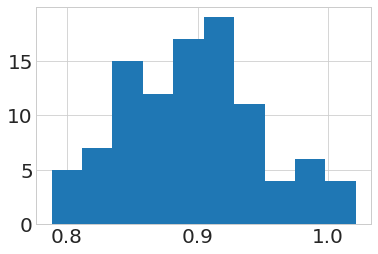

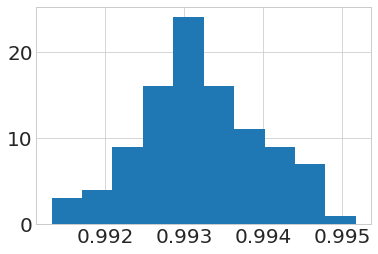

In [13]:
#####################################################
# Choosing training setting for Q-learning
#####################################################

# Create true model
env = StateGame()
env.reset()

agent = AGENT(env) # AgentQLearning(env) # 
## When want to test a learn model with epsilon/ci bounds
#env = #copy(model_robust)
    
Q_s0_a0 = []
Q_s0_a1 = []
n_trials = 100
for i in range(n_trials):
    # Perfect knowledge agent
    policy_perfect, V_perfect = agent.train_model_based(env, num_episodes=2000, discount_factor=1.0, alpha=0.005, epsilon=1.0)
    Q_s0_a0.append(agent.Q[0][0])
    Q_s0_a1.append(agent.Q[0][1])   

_, _ = plt.subplots()
plt.hist(Q_s0_a0)
_, _ = plt.subplots()
plt.hist(Q_s0_a1)

print("True Q_s0_a0 = ", env.reward_left_good*env.nu_left + (1-env.nu_left) * env.reward_left_bad )
print("True Q_s0_a1 = ", env.reward * env.nu_right)

print("Estimated Q_s0_a0 = ", sum(Q_s0_a0) / n_trials)
print("Estimated Q_s0_a1 = ", sum(Q_s0_a1) / n_trials)

## **Incorporate $\epsilon$-robustness**

In [14]:
# def create_reward_matrix(env):
#     """ 
#     Create the reward matrix of shape S x A x S for the environment model.
#     """
#     R = np.zeros(shape=(env.nS, env.nA, env.nS), dtype=float)
    
#     for s in range(env.nS):  # env.P.keys():
#         for a in range(env.nA):  # env.P[s].keys():
#             for trans in env.P[s][a]:
#                 transition_prob, s_prime, reward, done = trans
#                 # If not terminal
#                 if s != s_prime and s_prime == 1:
#                     R[s,a,s_prime] = env.reward_left_good
#                 else:
#                     R[s,a,s_prime] = reward
#     return R

def create_reward_matrix(env):
    """ 
    Create the reward matrix of shape S x A x S for the environment model.
    """
    R = np.zeros(shape=(env.nS, env.nA, env.nS), dtype=float)
    
    for s in range(env.nS):  # env.P.keys():
        for a in range(env.nA):  # env.P[s].keys():
            for s_prime in range(env.nS):
                
                def _check_reward(model, state, next_state, action):
                    if state != 0:
                        return 0 
                    if state == 0 and next_state == 1:
                        return model.reward_left_good
                    elif state == 0 and next_state == 2:
                        return model.reward_left_bad
                    # One option left state == 0 and action == 1 and next_state == 3
                    else:
                        return model.reward
                
                R[s,a,s_prime] = _check_reward(env, s, s_prime, a)
                
    return R

In [15]:
R = create_reward_matrix(env)
R.shape

(4, 2, 4)

 - **Run robust planning for the worst-case transition within L1 square**

In [16]:
def get_nu_s_a_hat_min(state, action, T, R, epsilon_robust):
    """
    Args:
        R (numpy.array): should be derived from model 
    """
    nu_s_a = T[state, action].squeeze().copy()
    r_s_a = R[state, action].squeeze().copy()
    
    calc_expected_gain = lambda nu_s_a_hat: nu_s_a_hat.dot(r_s_a.T)
    
    def _calc_distance_l1(nu_s_a_hat):
        """
        Works with the optimization task. 
        Note, to shift 0.5 mass from one bin to another epsilon should be 1: 
           - because the other bin changes mass and that is accounted.
           
        TODO: nu_s_a is defined outside of the function
        """
        return - cdist(nu_s_a_hat.reshape((1,-1)), nu_s_a.reshape((1,-1)), 'cityblock')[0] + epsilon_robust
    
    # Constraints
    distance_constraint = {'type': 'ineq', 'fun': _calc_distance_l1}
    # We nu_s_a is a pmf, so entries should sum to one 
    calc_pmf_sum = lambda nu_s_a_hat: nu_s_a_hat.sum() - 1
    pmf_constraint = {'type': 'eq', 'fun': calc_pmf_sum}
    # All entries nonnegative 
    bounds = tuple([(0, 1) for _ in nu_s_a])

    res = minimize(calc_expected_gain, nu_s_a, method='trust-constr', constraints=[pmf_constraint, distance_constraint], options={'verbose': 0, 'disp':False}, bounds=bounds)
    
    ## DIRTY DEALING WITH NUMERICAL STABILITY 
    #     if sum(res.x) != 1:
    #         logging.warning(f"Nu_s_a probabilities do not sum up to 1, but to {sum(res.x)}")
    #         logging.warning(f" After adjustment: {sum(res.x + (1 - sum(res.x)) / len(res.x))}")
    #         if sum(res.x + (1 - sum(res.x)) / len(res.x)) != 1:
    #             logging.warning(f"Even now they do not sum to 1, but to {sum(res.x)}")
    #             logging.warning( sum(res.x + (1 - sum(res.x)) / len(res.x)) )
    #             return res.x + np.finfo(float).eps if (sum(res.x))<1 else res.x-np.finfo(float).eps
    #         return res.x + (1 - sum(res.x)) / len(res.x)
    
    return res.x.copy() 

In [20]:
# Create the true model
env = StateGame()
P = env.P
T_true = env.generate_transition_matrix()

# Try to learn the model 
n_experience_tuples = 1000
experience = generate_experience(env, n_experience_tuples)
model = learn_model(env, experience, seed=None)

# print("--------- Model transition dict ---------")
# pp.pprint(model.experience_dict)
# print()
# print("--------- Estimated T ---------")
# print(model.T)
# print()

def get_epsilon_robust_model(model, epsilon_robust):
    """ 
    Returns learnt model where T is adjusted to the worst-case scenario.
    """
    # Create dynamics matrix which will hold the worst transition dynamics (on the distance radius epsilon_robust)
    T_min = model.T.copy()

    # Get reward matrix
    R = create_reward_matrix(model)
    
    # Given that our distance metric is just L1 (abolute diffs):
    #   For each nonterminal state and action, I want to find nu_s_a that minimizes "expected gain" (to be defined later) 
    for state in [0]:
        for action in range(env.nA):
            T_min[state,action,0,:] = get_nu_s_a_hat_min(state, action, model.T.copy(), R.copy(), epsilon_robust)
            
            print(get_nu_s_a_hat_min(state, action, model.T.copy(), R.copy(), epsilon_robust))
            # Modify transition probabilities in the model to T_min
            model.T = T_min.copy()
            # Modifies P in `model`
            model.create_transition_dict()        
    
    return model

# epsilon for the ball around reference dynamics
epsilon_robust = 0.1
# Robust model 
model_robust = get_epsilon_robust_model(copy(model), epsilon_robust)
        
# print(f"--------- Worst-case estimated T for epsilon = {epsilon_robust} ---------")
# print(model_robust.T)
# print()
        
# # Record estimated Q value
agent = AGENT(model_robust) # AgentQLearning(model_robust) #
# Usually you want to run the agent untill convergence
policy, V = agent.train_model_based(env=model_robust, num_episodes=10000, alpha=0.01, epsilon=0.5)

# Why do we have Q[0][1] > 1 ?
# print(agent.Q[0][0])
# print(agent.Q[0][1])

/home/romaks/anaconda3/envs/prim/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


[2.54068973e-05 4.01226190e-01 5.98722996e-01 2.54068973e-05]
[3.42704319e-05 1.05048633e-05 4.99039020e-02 9.50051323e-01]


- Run imaginary `main()` function 

In [ ]:
ALPHA_DEGRAD_DICT = {201: 0.05, 501: 0.05, 10001: 0.01}

In [ ]:
# Number of experiments per each experience volume 
n_experiments = 10
seeds = list(map(int, np.absolute((np.random.rand(n_experiments) * 1000)).tolist()))
# [10, 20, 50, 70, 100, 200, 500, 1000, 2000, 4000] 
experience_volumes = EXPERIENCE_VOLUMES
# Create true model
env = StateGame()
P = env.P
T_true = env.generate_transition_matrix()

# Store for plotting
model_divergence_errors_final = np.zeros((1,n_experiments))
model_big_errs_count_final = np.zeros((1,n_experiments))
Q_vals_s0_a0_final = np.zeros((1,n_experiments)) 
Q_vals_s0_a1_final = np.zeros((1,n_experiments)) 
nu_vals_final = np.zeros((1,n_experiments))
# Robust means 'worst-case'
Q_vals_robust_s0_a0_final = np.zeros((1,n_experiments)) 
Q_vals_robust_s0_a1_final = np.zeros((1,n_experiments)) 
nu_vals_robust_final = np.zeros((1,n_experiments))
nu_a1_vals_robust_final = np.zeros((1,n_experiments))

# Plan for each experiene volume
for n_experience_tuples in experience_volumes:
    # Make plot to see if there is convergence
    model_divergence_errors = []
    model_big_errs_count = []
    # In real setting we need to evaluate on a path, then collect returns
    Q_vals_s0_a0 = [] 
    Q_vals_s0_a1 = [] 
    nu_vals = []
    Q_vals_robust_s0_a0 = [] 
    Q_vals_robust_s0_a1 = [] 
    nu_vals_robust = []
    nu_a1_vals_robust = []
    
    for i in range(n_experiments):
        seed = None #seeds[i]
        experience = generate_experience(env, n_experience_tuples)
        model = learn_model(env, experience, seed=seed)
        nu_vals.append(model.P[0][0][0][0])
        
        # Run a planning algorithm with the available model
        agent = AGENT(model) #AgentDPCustom(model) #AgentQLearning(model) # 
        alpha_lvl = np.digitize(n_experience_tuples, ALPHA_LIST)
        alpha = ALPHA_DEGRAD_DICT[list(ALPHA_DEGRAD_DICT.keys())[alpha_lvl-1]]
        num_episodes = 500 if alpha >0.01 else 1000  # n_experience_tuples  # 
        # Usually you want to run the agent untill convergence
        policy, V = agent.train_model_based(env=model, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)
        # Record estimated Q value
        Q_vals_s0_a0.append(agent.Q[0][0])
        Q_vals_s0_a1.append(agent.Q[0][1])

        # Record for evaluation/plotting
        model_divergence_errors.append(divergence_value)
        model_big_errs_count.append(count)
        
        # Run robust planning
        epsilon_robust = 0.1
        model_robust = get_epsilon_robust_model(model, epsilon_robust)
        
        ## Because of numerical optimization: discrete probability functions nu_s_a might not sum to 1
        #if model_robust.T.sum().sum().sum().sum() != 8:
        #logging.warning(f"Wrong transition matrix. Nu_hats are do not sum to correct val. sum(T) = {model_robust.T.sum().sum().sum().sum().sum()}")
        
        # Record nu worst-case
        nu_vals_robust.append(model_robust.P[0][0][1][0])
        nu_a1_vals_robust.append(model_robust.P[0][1][3][0])
        # Run the same planning algorithm with the available model
        agent = AGENT(model_robust) #AgentDPCustom(model_robust) # AgentQLearning(model_robust) #
        # Usually you want to run the agent untill convergence
        policy, V = agent.train_model_based(env=model_robust, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)
        
        # Record estimated Q value
        Q_vals_robust_s0_a0.append(agent.Q[0][0])
        Q_vals_robust_s0_a1.append(agent.Q[0][1])
          
    print("N experience tuples: ", n_experience_tuples)
    print("Estimate of robust s_0: ", model_robust.P[0])
    
    # What we will be plotting 
#     model_divergence_errors_final.append(sum(model_divergence_errors)/n_experiments)
#     model_big_errs_count_final.append(sum(model_big_errs_count)/n_experiments)
#     Q_vals_s0_a0_final.append(sum(Q_vals_s0_a0)/n_experiments) 
#     Q_vals_s0_a1_final.append(sum(Q_vals_s0_a1)/n_experiments) 
#     nu_vals_final.append(sum(nu_vals)/n_experiments)
    
#     Q_vals_robust_s0_a0_final.append(sum(Q_vals_robust_s0_a0)/n_experiments) 
#     Q_vals_robust_s0_a1_final.append(sum(Q_vals_robust_s0_a1)/n_experiments) 
#     nu_vals_robust_final.append(sum(nu_vals_robust)/n_experiments)
#     nu_a1_vals_robust_final.append(sum(nu_a1_vals_robust)/n_experiments)   

    model_divergence_errors_final = np.array(np.vstack([model_divergence_errors_final, model_divergence_errors]))
    model_big_errs_count_final = np.array(np.vstack([model_big_errs_count_final, model_big_errs_count]))
    
    Q_vals_s0_a0_final = np.array(np.vstack([Q_vals_s0_a0_final, Q_vals_s0_a0]))
    Q_vals_s0_a1_final = np.array(np.vstack([Q_vals_s0_a1_final, Q_vals_s0_a1]))
    nu_vals_final = np.array(np.vstack([nu_vals_final, nu_vals]))
    
    Q_vals_robust_s0_a0_final = np.array(np.vstack([Q_vals_robust_s0_a0_final, Q_vals_robust_s0_a0])) 
    Q_vals_robust_s0_a1_final = np.array(np.vstack([Q_vals_robust_s0_a1_final, Q_vals_robust_s0_a1])) 
    nu_vals_robust_final = np.array(np.vstack([nu_vals_robust_final, nu_vals_robust]))
    nu_a1_vals_robust_final = np.array(np.vstack([nu_a1_vals_robust_final, nu_a1_vals_robust]))    

In [ ]:
# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(26,5)) 

plt.title(f"State-Game: Evaluating Performance", fontsize=20)

color_a0 = 'tab:red'
color_a0_robust = 'tab:orange'
color_a1 = 'tab:green'
color_a1_robust = 'lime'

ax1.plot(x_range, Q_vals_s0_a0_final[1:].mean(axis=1), color=color_a0, label="Q(s=0, a=0)", linewidth=3)
# ax1.plot(x_range, Q_vals_s0_a0_final[1:], color=color_a0)
# ax1.plot(x_range, Q_vals_s0_a0_final[1:].mean(axis=1) - Q_vals_s0_a0_final[1:].std(axis=1), color=color_a0)
# ax1.plot(x_range, Q_vals_s0_a0_final[1:].mean(axis=1) + Q_vals_s0_a0_final[1:].std(axis=1), color=color_a0)
ax1.fill_between(x_range, Q_vals_s0_a0_final[1:].mean(axis=1) - Q_vals_s0_a0_final[1:].std(axis=1), 
                 Q_vals_s0_a0_final[1:].mean(axis=1) + Q_vals_s0_a0_final[1:].std(axis=1), 
                 color=color_a0, alpha=0.3)

ax1.plot(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1), color=color_a0_robust, label="Q(s=0, a=0) robust", linewidth=3)
# ax1.plot(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1) - Q_vals_robust_s0_a0_final[1:].std(axis=1), color=color_a0_robust)
# ax1.plot(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1) + Q_vals_robust_s0_a0_final[1:].std(axis=1), color=color_a0_robust)
ax1.fill_between(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1) - Q_vals_robust_s0_a0_final[1:].std(axis=1), 
                 Q_vals_robust_s0_a0_final[1:].mean(axis=1) + Q_vals_robust_s0_a0_final[1:].std(axis=1), 
                 color=color_a0_robust, alpha=0.3)

ax1.plot(x_range, Q_vals_s0_a1_final[1:].mean(axis=1), color=color_a1, label="Q(s=0, a=1)", linewidth=3)
# ax1.plot(x_range, Q_vals_s0_a1_final[1:].mean(axis=1) - Q_vals_s0_a1_final[1:].std(axis=1),color=color_a1, )
# ax1.plot(x_range, Q_vals_s0_a1_final[1:].mean(axis=1) + Q_vals_s0_a1_final[1:].std(axis=1),color=color_a1, )
ax1.fill_between(x_range, Q_vals_s0_a1_final[1:].mean(axis=1) - Q_vals_s0_a1_final[1:].std(axis=1), 
                 Q_vals_s0_a1_final[1:].mean(axis=1) + Q_vals_s0_a1_final[1:].std(axis=1), 
                 color=color_a1, alpha=0.3)

ax1.plot(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1), color=color_a1_robust, label="Q(s=0, a=1) robust", linewidth=3)
# ax1.plot(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1) - Q_vals_robust_s0_a1_final[1:].std(axis=1), color=color_a1_robust)
# ax1.plot(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1) + Q_vals_robust_s0_a1_final[1:].std(axis=1), color=color_a1_robust)
# ax1.fill_between(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1) - Q_vals_robust_s0_a1_final[1:].std(axis=1), 
#                  Q_vals_robust_s0_a1_final[1:].mean(axis=1) + Q_vals_robust_s0_a1_final[1:].std(axis=1), 
#                  color=color_a1_robust, alpha=0.3)

# Horizontal line for expected value of Q_s0_a0 and Q_s0_a1
ax1.axhline(y=(env.reward_left_good*env.nu_left + (1-env.nu_left)*env.reward_left_bad),
            xmin=0, xmax=3, c=color_a0, linewidth=4, zorder=0, alpha=0.4, label="Expected Q(s=0, a=0)")
ax1.axhline(y=(env.reward * env.nu_right), xmin=0, xmax=3, c=color_a1, linewidth=4, zorder=0, 
            alpha=0.2, label="Expected Q(s=0, a=1)")
ax1.yaxis.grid(True)
ax1.set_ylabel("Reward/Return")

ax1.legend(loc='center right', bbox_to_anchor=(1.27, 0.5), ncol=1, fancybox=True, shadow=True)
# Choose how xticks presented  
# plt.xticks(x_range, list(map(str,x_ticks)))
# plt.xticks(x_range, x_ticks)
plt.xscale('log')
plt.xlabel('Log experience tuples')

fig.tight_layout()  
plt.show()

print()

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(26,5)) 

plt.title(f"State-Game: Learning Transitions", fontsize=20)

color_nu_s0_a0_s1 = 'tab:red'
color_nu_s0_a0_s1_worst_case = 'tab:orange'
color_a1 = 'tab:green'

# We already handled the x-label with ax1
ax2.plot(x_range, nu_vals_final[1:].mean(axis=1), color=color_nu_s0_a0_s1, label='Nu left (estimated)', linewidth=3)
ax2.fill_between(x_range, nu_vals_final[1:].mean(axis=1) - nu_vals_final[1:].std(axis=1), 
                 nu_vals_final[1:].mean(axis=1) + nu_vals_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1, alpha=0.3)

ax2.plot(x_range, nu_vals_robust_final[1:].mean(axis=1), color=color_nu_s0_a0_s1_worst_case, label='Nu left (worst-case)', linewidth=3)
ax2.fill_between(x_range, nu_vals_robust_final[1:].mean(axis=1) - nu_vals_robust_final[1:].std(axis=1), 
                 nu_vals_robust_final[1:].mean(axis=1) + nu_vals_robust_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1_worst_case, alpha=0.3)

ax2.plot(x_range, [env.nu_right]*len(x_range), color=color_a1, label='Nu right (estimated)', linewidth=3)

ax2.plot(x_range, nu_a1_vals_robust_final[1:].mean(axis=1), color=color_a1_robust, label='Nu right (worst-case)', linewidth=3)
ax2.fill_between(x_range, nu_a1_vals_robust_final[1:].mean(axis=1) - nu_a1_vals_robust_final[1:].std(axis=1), 
                 nu_a1_vals_robust_final[1:].mean(axis=1) + nu_a1_vals_robust_final[1:].std(axis=1), 
                 color=color_a1, alpha=0.3)

ax2.set_ylabel("Probability")

ax2.axhline(y=env.nu_left, xmin=0, xmax=3, c=color_nu_s0_a0_s1, linewidth=4, zorder=0, alpha=0.3, label="Nu left (true)")
ax2.axhline(y=env.nu_right, xmin=0, xmax=3, c=color_a1, linewidth=4, zorder=0, alpha=0.3, label="Nu right (true)")


# Choose how xticks presented  
# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax2.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fancybox=True, shadow=True)
ax2.yaxis.grid(True)

fig.tight_layout()  
plt.show()

 - (Q-learning) Why are "robust" Q value for s0 a1 are bigger than 1? 

## Robustness with Confidence Intrevals 

In [ ]:
def get_nu_s_a_hat_min_ci(model, state, action, T, R, alpha=0.05, cost_matrix=None):
    """
    """
    nu_s_a = T[state, action].squeeze().copy()
    r_s_a = R[state, action].squeeze().copy()
    calc_expected_gain = lambda nu_s_a_hat: nu_s_a_hat.dot(r_s_a.T)
    
    nu_s_a_hat_lower, nu_s_a_hat_upper  = proportion_confint(model.experience_dict[state][action]['count'], model.experience_dict[state][action]['count'].sum(), 
                                                             alpha=alpha, method='wilson')
    
    def _calc_distance_l1_lower(nu_s_a_hat):
        """
        Works with the optimization task. 
        Note, to shift 0.5 mass from one bin to another epsilon should be 1: 
           - because the other bin changes mass and that is accounted.
           
        TODO: nu_s_a is defined outside of the function
        """
        return nu_s_a_hat - nu_s_a_hat_lower
    
    def _calc_distance_l1_upper(nu_s_a_hat):
        """
        Works with the optimization task. 
        Note, to shift 0.5 mass from one bin to another epsilon should be 1: 
           - because the other bin changes mass and that is accounted.
           
        TODO: nu_s_a is defined outside of the function
        """
        return nu_s_a_hat_upper - nu_s_a_hat
    
    # Constraints
    distance_constraint_lower = {'type': 'ineq', 'fun': _calc_distance_l1_lower}
    distance_constraint_upper = {'type': 'ineq', 'fun': _calc_distance_l1_upper}
    
    # We nu_s_a is a pmf, so entries should sum to one 
    calc_pmf_sum = lambda nu_s_a_hat: nu_s_a_hat.sum() - 1
    pmf_constraint = {'type': 'eq', 'fun': calc_pmf_sum}
    # All entries nonnegative 
    bounds = tuple([(0, 1) for _ in nu_s_a])

    res = minimize(calc_expected_gain, nu_s_a, method='trust-constr', constraints=[pmf_constraint, distance_constraint_lower, distance_constraint_upper],
                   options={'verbose': 0, 'disp':False}, bounds=bounds)
    
    ## DIRTY DEALING WITH NUMERICAL STABILITY 
#     if sum(res.x) != 1:
#         logger.info(f"Nu_s_a probabilities do not sum up to 1, but to {sum(res.x)}")
#         logger.info(f" After adjustment: {sum(res.x + (1 - sum(res.x)) / len(res.x))}")
#         if sum(res.x + (1 - sum(res.x)) / len(res.x)) != 1:
#             logger.info(f"Even now they do not sum to 1, but to {sum(res.x)}")
#             logger.info( sum(res.x + (1 - sum(res.x)) / len(res.x)) )
#             return res.x + np.finfo(float).eps if (sum(res.x))<1 else res.x-np.finfo(float).eps
#         return res.x + (1 - sum(res.x)) / len(res.x)
    
    return res.x.copy() 

In [ ]:
# Create the true model
env = StateGame()
P = env.P
T_true = env.generate_transition_matrix()

# Try to learn the model 
n_experience_tuples = 6000
experience = generate_experience(env, n_experience_tuples)
model = learn_model(env, experience, seed=None)

#print("--------- Model transition dict ---------")
#pp.pprint(model.experience_dict)
#print("--------- Estimated T ---------")
#print(model.T)
#print()

def get_robust_model_ci(model, alpha):
    """ 
    Returns learnt model where T is adjusted to the worst-case scenario in Confidence Interval. 
    """
    # Create dynamics matrix which will hold the worst transition dynamics (on the distance radius epsilon_robust)
    T_min = model.T.copy()

    # Get reward matrix
    R = create_reward_matrix(model)
    
    # Given that our distance metric is just L1 (abolute diffs):
    #   For each nonterminal state and action, I want to find nu_s_a that minimizes "expected gain" (to be defined later) 
    for state in [0]:
        for action in range(env.nA):
            T_min[state,action,0,:] = get_nu_s_a_hat_min_ci(model, state, action, model.T.copy(), R.copy(), alpha)
            # Modify transition probabilities in the model to T_min
            model.T = T_min.copy()
            # Modifies P in `model`
            model.create_transition_dict()        
    
    return model

## CI @ 1-alpha
alpha = 0.1
## Robust model 
model_robust_ci = get_robust_model_ci(copy(model), alpha)
        
# print("--------- Worst-case (in CI) estimated T  ---------")
# print(model_robust_ci.T)
# print()
        
# # Record estimated Q value

agent =  AGENT(model_robust_ci) #AgentQLearning(model_robust_ci) #AgentDP() #
# Usually you want to run the agent untill convergence
policy, V = agent.train_model_based(env=model_robust_ci, num_episodes=500, alpha=0.1, epsilon=1)

# Why do we have Q[0][1] > 1 ?
# print(agent.Q[0][0])
# print(agent.Q[0][1])

In [ ]:
# Number of experiments per each experience volume 
n_experiments = 20
# [10, 20, 50, 70, 100, 200, 500, 1000, 2000, 4000]
experience_volumes = EXPERIENCE_VOLUMES
# Create true model
env = StateGame()
P = env.P
T_true = env.generate_transition_matrix()

# Store stats
model_divergence_errors_final = np.zeros((1, n_experiments))
model_big_errs_count_final = np.zeros((1, n_experiments))
Q_vals_s0_a0_final = np.zeros((1, n_experiments))
Q_vals_s0_a1_final = np.zeros((1, n_experiments))
nu_vals_final = np.zeros((1, n_experiments))
Q_vals_robust_s0_a0_final = np.zeros((1, n_experiments))
Q_vals_robust_s0_a1_final = np.zeros((1, n_experiments))
nu_vals_robust_ci_lower_final = np.zeros((1, n_experiments))
nu_vals_robust_ci_upper_final = np.zeros((1, n_experiments))
nu_vals_a1_robust_ci_lower_final = np.zeros((1, n_experiments))
nu_vals_a1_robust_ci_upper_final = np.zeros((1, n_experiments))

# Plan for each experiene volume
for n_experience_tuples in experience_volumes:
    # Make plot to see if there is convergence
    model_divergence_errors = []
    model_big_errs_count = []
    # In real setting we need to evaluate on a path, then collect returns
    Q_vals_s0_a0 = [] 
    Q_vals_s0_a1 = [] 
    nu_vals = []
    Q_vals_robust_s0_a0 = [] 
    Q_vals_robust_s0_a1 = [] 
    nu_vals_robust_ci_lower = []
    nu_vals_robust_ci_upper = []
    nu_vals_a1_robust_ci_lower = []
    nu_vals_a1_robust_ci_upper = []
    
    for _ in range(n_experiments):
        seed = None
        experience = generate_experience(env, n_experience_tuples)
        model = learn_model(env, experience, seed=seed)
        # Record nu 
        nu_vals.append(model.P[0][0][0][0])
        
        # Run a planning algorithm with the available model
        agent = AGENT(model) #AgentDPCustom(model) # AgentQLearning(model) #
        alpha_lvl = np.digitize(n_experience_tuples, ALPHA_LIST)
        alpha = ALPHA_DEGRAD_DICT[list(ALPHA_DEGRAD_DICT.keys())[alpha_lvl-1]]
        num_episodes = 500 if alpha >0.01 else 1000 # n_experience_tuples  # 
        # Usually you want to run the agent untill convergence
        policy, V = agent.train_model_based(env=model, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)
        # Record estimated Q value
        Q_vals_s0_a0.append(agent.Q[0][0])
        Q_vals_s0_a1.append(agent.Q[0][1])
       
        # To plot later
        nu_s_a_hat_lower, nu_s_a_hat_upper = proportion_confint(model.experience_dict[0][0]['count'], model.experience_dict[0][0]['count'].sum(),  
                                                                alpha=ALPHA_CI, method='wilson')
        nu_s_a1_hat_lower, nu_s_a1_hat_upper = proportion_confint(model.experience_dict[0][1]['count'], model.experience_dict[0][1]['count'].sum(),  
                                                                alpha=ALPHA_CI, method='wilson')
        # Record nu_s0_a0_s1 CI 
        nu_vals_robust_ci_lower.append(nu_s_a_hat_lower[1])
        nu_vals_robust_ci_upper.append(nu_s_a_hat_upper[1])
        nu_vals_a1_robust_ci_lower.append(nu_s_a1_hat_lower[3])
        nu_vals_a1_robust_ci_upper.append(nu_s_a1_hat_upper[3])
        
        # Run robust planning with CI        
        model_robust_ci = get_robust_model_ci(copy(model), alpha=alpha)

        #if model_robust_ci.T.sum().sum().sum().sum() != 8:
        #   logging.warning(f"Wrong transition matrix. Nu_hats are do not sum to correct val. sum(T) = {model_robust_ci.T.sum().sum().sum().sum().sum()}")

        # Run the same planning algorithm with the available model
        agent = AGENT(model_robust_ci)  # AgentDPCustom(model_robust_ci) # AgentQLearning(model_robust_ci) # AgentDP() #
        # Usually you want to run the agent untill convergence
        policy, V = agent.train_model_based(env=model_robust_ci, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)
        
        # Record estimated Q value
        Q_vals_robust_s0_a0.append(agent.Q[0][0])
        Q_vals_robust_s0_a1.append(agent.Q[0][1])
          
    print("N experience tuples: ", n_experience_tuples)
    print("Estimate of s_0: ", model_robust_ci.P[0])
    
    # What we will be plotting 
#     model_divergence_errors_final = np.vstack([model_divergence_errors_final, model_divergence_errors])
#     model_big_errs_count_final = np.vstack([model_big_errs_count_final, model_big_errs_count])
    Q_vals_s0_a0_final = np.vstack([Q_vals_s0_a0_final, Q_vals_s0_a0]) 
    Q_vals_s0_a1_final = np.vstack([Q_vals_s0_a1_final, Q_vals_s0_a1]) 
    nu_vals_final = np.vstack([nu_vals_final, nu_vals])
    Q_vals_robust_s0_a0_final = np.vstack([Q_vals_robust_s0_a0_final, Q_vals_robust_s0_a0]) 
    Q_vals_robust_s0_a1_final = np.vstack([Q_vals_robust_s0_a1_final, Q_vals_robust_s0_a1]) 
    nu_vals_robust_ci_lower_final = np.vstack([nu_vals_robust_ci_lower_final, nu_vals_robust_ci_lower])
    nu_vals_robust_ci_upper_final = np.vstack([nu_vals_robust_ci_upper_final, nu_vals_robust_ci_upper])
    nu_vals_a1_robust_ci_lower_final = np.vstack([nu_vals_a1_robust_ci_lower_final, nu_vals_a1_robust_ci_lower])
    nu_vals_a1_robust_ci_upper_final = np.vstack([nu_vals_a1_robust_ci_upper_final, nu_vals_a1_robust_ci_upper])

In [ ]:
# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(26,5))

plt.title(f"State-Game: Evaluating Performance", fontsize=25)

color_a0 = 'tab:red'
color_a0_robust = 'tab:orange'
color_a1 = 'tab:green'
color_a1_robust = 'lightgreen'

ax1.plot(x_range, Q_vals_s0_a0_final[1:].mean(axis=1), color=color_a0, label="Q(s=0, a=0)", linewidth=3)
ax1.fill_between(x_range, Q_vals_s0_a0_final[1:].mean(axis=1) - Q_vals_s0_a0_final[1:].std(axis=1), 
                 Q_vals_s0_a0_final[1:].mean(axis=1) + Q_vals_s0_a0_final[1:].std(axis=1), 
                 color=color_a0, alpha=0.3)

ax1.plot(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1), color=color_a0_robust, label="Q(s=0, a=0) robust", linewidth=3)
ax1.fill_between(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1) - Q_vals_robust_s0_a0_final[1:].std(axis=1), 
                 Q_vals_robust_s0_a0_final[1:].mean(axis=1) + Q_vals_robust_s0_a0_final[1:].std(axis=1), 
                 color=color_a0_robust, alpha=0.3)

ax1.plot(x_range, Q_vals_s0_a1_final[1:].mean(axis=1), color=color_a1, label="Q(s=0, a=1)", linewidth=3)
ax1.fill_between(x_range, Q_vals_s0_a1_final[1:].mean(axis=1) - Q_vals_s0_a1_final[1:].std(axis=1), 
                 Q_vals_s0_a1_final[1:].mean(axis=1) + Q_vals_s0_a1_final[1:].std(axis=1), 
                 color=color_a1, alpha=0.3)

ax1.plot(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1), color=color_a1_robust, label="Q(s=0, a=1) robust", linewidth=3)
ax1.fill_between(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1) - Q_vals_robust_s0_a1_final[1:].std(axis=1), 
                 Q_vals_robust_s0_a1_final[1:].mean(axis=1) + Q_vals_robust_s0_a1_final[1:].std(axis=1), 
                 color=color_a1_robust, alpha=0.3)

# Horizontal line for expected value of Q_s0_a0 and Q_s0_a1
ax1.axhline(y=(env.reward_left_good*env.nu_left + (1-env.nu_left)*env.reward_left_bad),
            xmin=0, xmax=3, c=color_a0, linewidth=4, zorder=0, alpha=0.4, label="Expected Q(s=0, a=0)")
ax1.axhline(y=(env.reward * env.nu_right), xmin=0, xmax=3, c=color_a1, linewidth=4, zorder=0, 
            alpha=0.2, label="Expected Q(s=0, a=1)")

# Choose how xticks presented  
# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax1.set_ylabel("Reward/Return")

ax1.legend(loc='center right', bbox_to_anchor=(1.27, 0.5), ncol=1, fancybox=True, shadow=True)

fig.tight_layout()  
plt.show()

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(26,5))

# fig.suptitle(f"Agent's performance for non-robsut and roust planning with learnt models", fontsize=20)
plt.title(f"State-Game: Learning Transitions", fontsize=25)

color_nu_s0_a0_s1 = 'tab:red'
color_nu_s0_a0_s1_worst_case = 'tab:orange'

# We already handled the x-label with ax1
ax2.plot(x_range, nu_vals_final[1:].mean(axis=1), color=color_nu_s0_a0_s1, label='Nu left (estimated)', linewidth=3)
ax2.fill_between(x_range, nu_vals_final[1:].mean(axis=1) - Q_vals_robust_s0_a1_final[1:].std(axis=1), 
                 nu_vals_final[1:].mean(axis=1) + nu_vals_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1, alpha=0.3)

ax2.plot(x_range, nu_vals_robust_ci_lower_final[1:].mean(axis=1), color=color_nu_s0_a0_s1_worst_case, label='Nu left (lower bound)')
ax2.fill_between(x_range, nu_vals_robust_ci_lower_final[1:].mean(axis=1) - nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 nu_vals_robust_ci_lower_final[1:].mean(axis=1) + nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1_worst_case, alpha=0.3)

ax2.plot(x_range, nu_vals_robust_ci_upper_final[1:].mean(axis=1), color=color_nu_s0_a0_s1_worst_case, label='Nu left (upper bound)')
ax2.fill_between(x_range, nu_vals_robust_ci_lower_final[1:].mean(axis=1) - nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 nu_vals_robust_ci_lower_final[1:].mean(axis=1) + nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1_worst_case, alpha=0.3)

ax2.plot(x_range, [env.nu_right]*len(x_range), color=color_a1, label='Nu right (estimated)', linewidth=3)

ax2.plot(x_range, nu_vals_a1_robust_ci_lower_final[1:].mean(axis=1), color=color_a1_robust, label='Nu right (lower bound)')
ax2.fill_between(x_range, nu_vals_a1_robust_ci_lower_final[1:].mean(axis=1) - nu_vals_a1_robust_ci_lower_final[1:].std(axis=1), 
                 nu_vals_a1_robust_ci_lower_final[1:].mean(axis=1) + nu_vals_a1_robust_ci_lower_final[1:].std(axis=1), 
                 color=color_a1_robust, alpha=0.3)

ax2.plot(x_range, nu_vals_a1_robust_ci_upper_final[1:].mean(axis=1), color=color_a1_robust, label='Nu right (upper bound)')

ax2.axhline(y=env.nu_left, xmin=0, xmax=3, c=color_nu_s0_a0_s1, linewidth=4, zorder=0, alpha=0.3, label="Nu left (true)")

ax2.axhline(y=env.nu_right, xmin=0, xmax=3, c=color_a1, linewidth=4, zorder=0, alpha=0.3, label="Nu right (true)")

ax2.set_ylabel("Probability")

# Choose how xticks presented  
# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax2.legend(loc='center right', bbox_to_anchor=(1.27, 0.5), ncol=1, fancybox=True, shadow=True)

# tight_layout, otherwise the right y-label is slightly clipped
fig.tight_layout()  
plt.show()

..

# Why we need robust planning/policies

We saw in the previous examples that planning with learnt models is subjective to the uncertainty surrounding estimated models. Notice oscullations of $Q(s_0, a_0)$ in the first stages of learning: when low number of examples is encountered, the agent may decide to act suboptimally. 

Next, we inspect what situations result in optimal and suboptimal performances depending on employing non-robust and robust methodology. We measure optimality in terms of regret which is defined as the difference between the expected returns between following the policy that maximizes rewards (optimal policy $\pi^*$ and the agent's learnt policy.

$$ Regret = \Delta_{G} = G^* - G^{\pi} $$


We hypothise that regret will depend on two factors: action-gap and amount of stochasticity in the system. The action-gap $g^∗_{Q(s)}$ is defined as the difference in (expected) $Q$-values between the optimal action $a_0$ and the nearest sub-optimal action $a_1$ for that state.

$$g^∗_{Q(s)} = |Q^∗_{(s_0, a_0)} − Q^∗_{(s_0, a_1)}| $$

$Q_{(s_0, a_0)}$ depends on entropy in the system (stochastic transitions) and the reward function. We see that starting from low entropy and increasing it to a certain point decreases the action gap. This point is identified by the ratio between the reward for the best action and reward for the next best action $\frac{r_{s,a,s'}}{r_{max}}$. 

In our problem, action gap has the following relationship with $\nu_{s_0, a_0}$, given rewards $r_{s_0, a_0, s'_1}$, $r_{s_0, a_0, s'_2}=0$ and $r_{s_0, a_1, s'_3}$. Starting from small $\nu_{s_0, a_0}$ and increasing it, decreases the peformance gap. When $\nu_{s_0, a_0}$ approaches $\frac{r_{s_0,a_0,s'_1}}{r_{s_0,a_1,s'_3}}$, the action gap is almost zero, however entropy in the system might be still high. Consider, $\nu_{s_0, a_0}$ = $\frac{r_{s_0,a_0,s'_1}}{r_{s_0,a_1,s'_3}} = \frac{100}{200}$. The action gap is zero, however there is still stochasticity in the system: 50% probability to transition to higher or lower reward state. If $\nu_{s_0, a_0}$ continues to rise, the peformance gap becomes larger again. But in that case, being robust can have negative consequences as worst-case $\nu_{s_0, a_0}$ becomes suboptimal if an agent wants to maximize its expected reward. 


In [ ]:
# How we calculate regret 
def get_delta_gain(nu_left_true, nu_left_hat, reward_high, reward, prob_a_switch):
    """
    Logic to calculate 'regret'. Based on the true nu_left and reward functions, we have different regret for robust policies and non-robust policies. 
    
    Args:
        nu (float, [0:1]): nu_left probability 
    """
    if nu_left_true > prob_a_switch:
        a_star = 0
        if nu_left_hat * reward_high >= reward:
            # a0 is optimal
            G_star = nu_left_true * reward_high
            G_pi = nu_left_true * reward_high
            a_pi = 0
        else:
            G_star = nu_left_true * reward_high
            G_pi = 1 * reward
            a_pi = 1
    else:
        a_star = 1
        if nu_left_hat * reward_high >= reward:
            # a1 is optimal
            G_star = reward
            G_pi = nu_left_true * reward_high
            a_pi = 0
        elif nu_left_hat * reward_high < reward:
            G_star = reward
            G_pi = reward
            a_pi = 1

    return G_star - G_pi

In [ ]:
# How we calculate regret 
def get_delta_gain(nu_left_true, nu_left_hat, reward_high, reward, prob_a_switch):
    """
    Logic to calculate 'regret'. Based on the true nu_left and reward functions, we have different regret for robust policies and non-robust policies. 
    
    Args:
        nu (float, [0:1]): nu_left probability 
    """
    if nu_left_true * reward_high > reward:
        # a_0 is optimal
        G_star = nu_left_true * reward_high
    else:
        # a_1 is optimal
        G_star = reward

    a_pi = np.argmax([nu_left_hat * reward_high, reward])

    G_pi = [nu_left_true * reward_high, reward][a_pi] 
    
    
    return G_star - G_pi

## Hypothesis 1 

For $\nu_{s_0, a_0, s_1}$.high entropy and high differences in rewards, we expect to robust policies perform better than non-robust.

We evaluate this by: 

- We sample true $\nu_{s_0, a_0, s_1}$.
- Then, we sample possible 'learnt' models from around the neighborhood of $\nu_{s_0, a_0, s_1}$.
- Next, we calculate regret for each of the 'learnt' models based on non-robust and (epsilon) robust methods.
- Record the regrets 

We measure the differences in rewards as $\frac{r_{s,a,s'}}{r_{max}}$ i.e. lower ratio corresponds to higher differences in rewards. If $ 0 < \nu_{s_0, a_0, s_1} \leq \frac{r_{s_0, a_1, s_3}}{r_{s_0, a_0, s_1}}$, the system is stochastic and taking a 'risky' action may result in (significantly) higher reward but also lead to zero reward $r_{s_0, a_0, s_2}=0$. 

In [ ]:
reward_high = 3
reward = 2.5

list_rewards_tuples = [(3,0.5), (3,1), (3,1.5), (3,2.0), (3,2.5), (3, 2.9), (3, 2.95), (3, 2.999)]

# Run test this many times
n_runs = 10
# Number of learn models for each nu_left 
n_models = 10 
# For robust 
epsilon_robust = 0.2
std_nu_left_hat = 0.2
std_nu_right_hat = 0.001

delta_gain_list = []
delta_gain_robust_list = []

# For plotting in a loop
fig, ax = plt.subplots(figsize=(15,10))
color_robust = 'tab:green'
color = 'tab:red'

for idx, x in enumerate(list_rewards_tuples):
    reward_high, reward = x
    x_idx_axes = idx % 2
    y_idx_axes = idx // 2
    
    # Different ranges of nu
    for nu_left_array in  [np.linspace(0, reward/reward_high, 20)]: # [np.linspace(0.0, 1.0, 50)]:  
        # Start with low nu's and go to higher nu's
        for _ in range(n_runs):
            for nu_left_true in nu_left_array:
                # Create model with that nu 
                env = StateGame(nu_left=nu_left_true, reward_left_good=reward_high, reward=reward)
                P = env.P
                T = env.generate_transition_matrix()

                # Sample several nu_hats and create 'learnt' models with them 
                for learnt_model_idx in range(n_models): 

                    ################ 
                    # Non-robust 
                    ################

                    # std_nu represents how many observations you had and stochasticity 
                    nu_left_hat = np.clip(np.random.normal(nu_left_true, std_nu_left_hat), a_min=0.0, a_max=1)  
                    # For deterministic transition sample around probability 1 
                    nu_right_hat = np.clip(np.random.normal(1, std_nu_right_hat), a_min=0.0, a_max=1)    
                    # Create 'learnt' model
                    model = StateGame(nu_left=nu_left_hat, nu_right=nu_right_hat)

                    # For each 'learnt' model : record regret (i.e. delta gain)
                    delta_gain = get_delta_gain(nu_left_true, nu_left_hat, env.reward_left_good, env.reward, env.reward/env.reward_left_good)
                    delta_gain_list.append(delta_gain)

                    ################ 
                    # Epsilon Robust 
                    ################

                    # All the time take the worst 
                    nu_left_hat_robust = nu_left_hat - epsilon_robust
                    nu_right_hat_robust = nu_right_hat - epsilon_robust 
                    delta_gain_robust = get_delta_gain(nu_left_true, nu_left_hat_robust, env.reward_left_good, env.reward, env.reward/env.reward_left_good)
                    delta_gain_robust_list.append(delta_gain_robust)
                    
        # Plotting
        plt.subplot(int(str(24) + str(idx+1)))
        n, bins, patches = plt.hist([delta_gain_list, delta_gain_robust_list], label=['non-robust', 'robust'], density=True, color=[color, color_robust])
        # Best fit of data: non-robust
        (mu, sigma) = norm.fit(delta_gain_list)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y, linewidth=2, c=color)
        # Best fit of data: robust
        (mu, sigma) = norm.fit(delta_gain_robust_list)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y, linewidth=2, c=color_robust)
        plt.title(f"Reward ratio {reward/reward_high:.2f}", fontsize=15)
    
# Add axis labels as text 
text(-0.1, 0.6,'Density', ha='center', va='center', transform=ax.transAxes, rotation=90, fontsize=20)
text(0.6, -0.1,'Regret',ha='center', va='center', transform=ax.transAxes, rotation=0, fontsize=20)
plt.show()

**Question: why do we see that robust policies perform better than non-robust only for some $\nu_{s_0, a_0}$'s?**

<!-- 
See histograms of frequencies of high regrets for different values of $\nu_{s_0, a_0}$ below. -->

**Answer: when facing similar expected rewards between optimal and suboptimal action, but having high entropy, the agent occures lower regret with robust policies.** 

 --- 

## Action gap vs entropy delta vs regret

In [ ]:
from scipy.stats import entropy
from scipy.optimize import fsolve, brute,  minimize_scalar

In [ ]:
e_arr_left = [entropy([x,1-x], base=2) for x in np.linspace(0, 1, 20)]
e_arr_right = [entropy([1,0],base=2) for x in np.linspace(0, 1, 20)]
d_e_arr = [(np.log2(nu_left) + 1) * (1/np.log2(2)) - (np.log2(1-nu_left) + 1) / np.log2(2) for nu_left in np.linspace(0, 1, 20)]

plt.plot(np.linspace(0, 1, 20), e_arr_left)
plt.plot(np.linspace(0, 1, 20), e_arr_right)
# Derivative of entrpopy for nu_left
# plt.plot(np.linspace(0, 1, 20), d_e_arr)
plt.show()

In [ ]:
def get_nu_left(e_delta, nu_big=False):
    """
    Get nu_left given entropy delta. We are missing Newton's quadratic convergence but with.
    
    e_delta should always be given positive. 
    
    If nu_big is True, then nu selected from [0.5:1] else from [0:0.5].  
    """
    ent_delta = lambda nu_left: abs(entropy([nu_left, 1 - nu_left], base=2) - e_delta)        
    
    res0 = minimize_scalar(ent_delta, bounds=(0.0, 0.5), method='bounded')
    
    res1 = minimize_scalar(ent_delta, bounds=(0.5, 1), method='bounded')
    
    return res0.x, res1.x

In [ ]:
def get_reward_ratio(a_gap, nu_left, left_optimal):
    # I can fix this 
    r_s0_a1_s3 = 1 
    if left_optimal:
        r_s0_a0_s1 = (a_gap + r_s0_a1_s3) / nu_left
    else:
        r_s0_a0_s1 = (r_s0_a1_s3 - a_gap) / nu_left
        
    return r_s0_a0_s1, r_s0_a1_s3

In [ ]:
# TESTING ENTROPY AND ACTION RATIO
# tups = [(0.1, 0.6), (0.2, 0.1), (0.3, 0.9), (0.4, 0.3), (0.5, 0.5), (0.25, 0.3), (0.15, 0.5)]

# for tup in tups:
#     # a_0 always optimal
#     nu_s, nu_b = get_nu_left(tup[0],True)
#     r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(tup[1], nu_s, True)
    
#     for nu in [nu_s, nu_b]:
#         if abs(entropy([nu, 1-nu]) - tup[0]) > 0.1:
#             print("entrp: ", tup)
#         elif r_s0_a0_s1 * nu - r_s0_a1_s3 > tup[1]:
#             print(nu)
#             print('act gap: ', tup)
#             print(r_s0_a0_s1 * nu - r_s0_a1_s3)
#             print(r_s0_a0_s1,r_s0_a1_s3 )
#             print()
#         else:
#             print(nu)
#             print(r_s0_a0_s1 * nu - r_s0_a1_s3)
#             print(r_s0_a0_s1,r_s0_a1_s3 )
#             print()

In [ ]:
# Run test this many times?
n_runs = 100
# Number of learnt models for each nu_left 
n_models = 10 
# For robust 
epsilon_robust = 0.1
std_nu_left_hat = 0.1
std_nu_right_hat = 0.001

results_grid = np.zeros(shape=(1, 4))

delta_gain_list = []
delta_gain_robust_list = []

step_delta_entropy = 0.1
step_delta_action = 0.1
# First entropy gap, later action gap
g = np.mgrid[-1.0:1.1:0.05, 0:1.:0.1]
a_e_mesh = list(zip(*(x.flat for x in g)))

for entropy_delta, action_gap in a_e_mesh:
        if entropy_delta < 0:
            nu_left_true_s, nu_left_true_b = get_nu_left(-entropy_delta, nu_big=False)
            r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=False)
            reward_high, reward = r_s0_a0_s1, r_s0_a1_s3
        else:
            nu_left_true_s, nu_left_true_b = get_nu_left(entropy_delta, nu_big=False)
            r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=True)
            reward_high, reward = r_s0_a0_s1, r_s0_a1_s3
        
        if nu_left_true == 0:
            print("What happened?")
            break
            
        for nu_left_true in [nu_left_true_s, nu_left_true_b]:
            for _ in range(n_runs):
                # Create model with that nu 
                env = StateGame(nu_left=nu_left_true, reward_left_good=reward_high, reward=reward)
                P = env.P
                T = env.generate_transition_matrix()

                # Sample several nu_hats and create 'learnt' models with them 
                for learnt_model_idx in range(n_models): 

                    # std_nu represents how many observations you had and stochasticity 
                    nu_left_hat = np.clip(np.random.normal(nu_left_true, std_nu_left_hat), a_min=0.0, a_max=1)  
                    # For deterministic transition sample around probability 1 
                    nu_right_hat = np.clip(np.random.normal(1, std_nu_right_hat), a_min=0.0, a_max=1)  
                    
                    ################ 
                    # Non-robust 
                    ################

                    # Create 'learnt' model
                    #model = StateGame(nu_left=nu_left_hat, nu_right=nu_right_hat)
                    # For each 'learnt' model : record regret (i.e. delta gain)
                    delta_gain = get_delta_gain(nu_left_true, nu_left_hat, env.reward_left_good, env.reward, env.reward / env.reward_left_good)
                    delta_gain_list.append(delta_gain)

                    ################ 
                    # Epsilon Robust 
                    ################

                    # All the time take the worst 
                    nu_left_hat_robust = nu_left_hat - epsilon_robust
                    nu_right_hat_robust = nu_right_hat #- epsilon_robust 
                    delta_gain_robust = get_delta_gain(nu_left_true, nu_left_hat_robust, env.reward_left_good, env.reward, env.reward / env.reward_left_good)
                    delta_gain_robust_list.append(delta_gain_robust)

        # For single nu_left_true we have n_runs estimations of regret
        x = action_gap
        y = entropy_delta
        z_non_robust = sum(delta_gain_list)/len(delta_gain_list)
        z_robust = sum(delta_gain_robust_list)/len(delta_gain_robust_list)

        result_row = np.array([x,y,z_non_robust, z_robust])
        results_grid = np.vstack([results_grid, result_row])

# Plot rewards
x = results_grid[1:, 0]                   
y = results_grid[1:, 1]                    
z_non_robust = results_grid[1:, 2] 
z_robust = results_grid[1:, 3] 

In [ ]:
# %matplotlib inline
# Plot next to each other
X, Y = g
fig, ax = plt.subplots(figsize=(10, 5))
heatmap = plt.pcolormesh(X,Y,z_robust.reshape(X.shape))
plt.colorbar(heatmap)
text(-0.1, 0.5,'Entropy Delta', ha='center', va='center', transform=ax.transAxes, rotation=90, fontsize=20)
text(0.5, -0.1,'Action Gap', ha='center', va='center', transform=ax.transAxes, rotation=0, fontsize=20)
plt.title("Robust", fontsize=25)
plt.show()

X, Y = g
fig, ax = plt.subplots(figsize=(10,5))
heatmap = plt.pcolormesh(X,Y,z_non_robust.reshape(X.shape))
plt.colorbar(heatmap)
text(-0.1, 0.5,'Entropy Delta', ha='center', va='center', transform=ax.transAxes, rotation=90, fontsize=20)
text(0.5, -0.1,'Action Gap', ha='center', va='center', transform=ax.transAxes, rotation=0, fontsize=20)
plt.title("Non-robust", fontsize=25)
plt.show()

# DIFFERENCES
X, Y = g
fig, ax = plt.subplots(figsize=(10,5))
heatmap = plt.pcolormesh(X,Y,z_robust.reshape(X.shape) - z_non_robust.reshape(X.shape))
plt.colorbar(heatmap)
text(-0.1, 0.5,'Entropy Delta', ha='center', va='center', transform=ax.transAxes, rotation=90, fontsize=20)
text(0.5, -0.1,'Action Gap', ha='center', va='center', transform=ax.transAxes, rotation=0, fontsize=20)
plt.title("Non-robust - Robust", fontsize=25)
plt.show()            

In [ ]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(14, 10))

color = 'red'
color_robust = 'green'

ax = fig.gca(projection="3d")
surf1 = ax.plot_trisurf(x, y, z_non_robust, linewidth=0.2, antialiased=True, alpha=0.8, label='non-robust', color=color)
surf1._facecolors2d=surf1._facecolors3d
surf1._edgecolors2d=surf1._edgecolors3d
surf2 = ax.plot_trisurf(x, y, z_robust, linewidth=0.2, antialiased=True, alpha=0.8, label='robust', color=color_robust)
surf2._facecolors2d=surf2._facecolors3d
surf2._edgecolors2d=surf2._edgecolors3d

ax.tick_params(axis='x', which='major', pad=10.0, rotation=20)
ax.tick_params(axis='y', which='major', pad=0.0, rotation=-40)
ax.tick_params(axis='z', which='major', pad=10.0)

ax.view_init(10, -20)

plt.title("Average Regret", fontsize=20)
ax.set_xlabel("Action Gap", labelpad=30)
ax.set_ylabel("Entropy Delta", labelpad=40)
ax.set_zlabel("Regret", labelpad=27)

plt.legend(loc='upper right', bbox_to_anchor=(0.6, .85), ncol=1, fancybox=True, shadow=True)
# fig.tight_layout()
plt.show()

## Evaluating with robust objective 

$$ f_\mathcal{V}(\pi) = \min_{\nu \in \mathcal{V}} \mathbb{E}_{{\tau} \sim p_{\pi, \nu}}[G({\tau}) ] $$

In [ ]:
# Run test this many times?
n_runs = 100
# Number of learnt models for each nu_left 
n_models = 10 
# For robust 
epsilon_robust = 0.1
std_nu_left_hat = 0.1
std_nu_right_hat = 0.001

results_grid = np.zeros(shape=(1, 4))

delta_gain_list = []
delta_gain_robust_list = []

step_delta_entropy = 0.1
step_delta_action = 0.1
# First entropy gap, later action gap
g = np.mgrid[-1.0:1.1:0.05, 0:1.:0.1]
a_e_mesh = list(zip(*(x.flat for x in g)))

for entropy_delta, action_gap in a_e_mesh:
        if entropy_delta < 0:
            nu_left_true_s, nu_left_true_b = get_nu_left(-entropy_delta, nu_big=False)
            r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=False)
            reward_high, reward = r_s0_a0_s1, r_s0_a1_s3
        else:
            nu_left_true_s, nu_left_true_b = get_nu_left(entropy_delta, nu_big=False)
            r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=True)
            reward_high, reward = r_s0_a0_s1, r_s0_a1_s3
        
        if nu_left_true == 0:
            print("What happened?")
            break
            
        for nu_left_true in [nu_left_true_s, nu_left_true_b]:
            for _ in range(n_runs):
                # Create model with that nu 
                env = StateGame(nu_left=nu_left_true, reward_left_good=reward_high, reward=reward)
                P = env.P
                T = env.generate_transition_matrix()

                # Sample several nu_hats and create 'learnt' models with them 
                for learnt_model_idx in range(n_models): 

                    # std_nu represents how many observations you had and stochasticity 
                    nu_left_hat = np.clip(np.random.normal(nu_left_true, std_nu_left_hat), a_min=0.0, a_max=1)  
                    # For deterministic transition sample around probability 1 
                    nu_right_hat = np.clip(np.random.normal(1, std_nu_right_hat), a_min=0.0, a_max=1)  
                    
                    ################ 
                    # Epsilon Robust 
                    ################

                    # All the time take the worst 
                    nu_left_hat_robust = nu_left_hat - epsilon_robust
                    nu_right_hat_robust = nu_right_hat #- epsilon_robust 
                    delta_gain_robust = get_delta_gain(nu_left_hat_robust, nu_left_hat_robust, env.reward_left_good, env.reward, env.reward / env.reward_left_good)
                    delta_gain_robust_list.append(delta_gain_robust)
                    
                    ################ 
                    # Non-robust 
                    ################

                    # Instead of nu_left_true, put the robust estimator
                    delta_gain = get_delta_gain(nu_left_hat_robust, nu_left_hat, env.reward_left_good, env.reward, env.reward / env.reward_left_good)
                    delta_gain_list.append(delta_gain)



        # For single nu_left_true we have n_runs estimations of regret
        x = action_gap
        y = entropy_delta
        z_non_robust = sum(delta_gain_list)/len(delta_gain_list)
        z_robust = sum(delta_gain_robust_list)/len(delta_gain_robust_list)

        result_row = np.array([x,y,z_non_robust, z_robust])
        results_grid = np.vstack([results_grid, result_row])

# Plot rewards
x = results_grid[1:, 0]                   
y = results_grid[1:, 1]                    
z_non_robust = results_grid[1:, 2] 
z_robust = results_grid[1:, 3] 

In [ ]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(14, 10))

color = 'red'
color_robust = 'green'

ax = fig.gca(projection="3d")
surf1 = ax.plot_trisurf(x, y, z_non_robust, linewidth=0.2, antialiased=True, alpha=0.8, label='non-robust', color=color)
surf1._facecolors2d=surf1._facecolors3d
surf1._edgecolors2d=surf1._edgecolors3d
surf2 = ax.plot_trisurf(x, y, z_robust, linewidth=0.2, antialiased=True, alpha=0.8, label='robust', color=color_robust)
surf2._facecolors2d=surf2._facecolors3d
surf2._edgecolors2d=surf2._edgecolors3d

ax.tick_params(axis='x', which='major', pad=10.0, rotation=-20)
ax.tick_params(axis='y', which='major', pad=0.0, rotation=-0)
ax.tick_params(axis='z', which='major', pad=10.0)

ax.view_init(15, 20)

plt.title("Average Regret", fontsize=20)
ax.set_xlabel("Action Gap", labelpad=30)
ax.set_ylabel("Entropy Delta", labelpad=25)
ax.set_zlabel("Regret", labelpad=27)

plt.legend(loc='upper right', bbox_to_anchor=(0.9, .85), ncol=1, fancybox=True, shadow=True)
# fig.tight_layout()
plt.show()

- Instead of regret evauate performance 

In [ ]:
def get_nu_left(e_delta, nu_big=False):
    """
    Get nu_left given entropy delta. We are missing Newton's quadratic convergence but with.
    
    e_delta should always be given positive. 
    
    If nu_big is True, then nu selected from [0.5:1] else from [0:0.5].  
    """
    ent_delta = lambda nu_left: abs(entropy([nu_left, 1 - nu_left], base=2) - e_delta)        
    
    res0 = minimize_scalar(ent_delta, bounds=(0.0, 0.5), method='bounded')
    
    res1 = minimize_scalar(ent_delta, bounds=(0.5, 1), method='bounded')
    
    return res0.x, res1.x

def get_reward_ratio(a_gap, nu_left, left_optimal):
    # I can fix this 
    r_s0_a1_s3 = 1 
    if left_optimal:
        r_s0_a0_s1 = (a_gap + r_s0_a1_s3) / nu_left
    else:
        r_s0_a0_s1 = (r_s0_a1_s3 - a_gap) / nu_left
        
    return r_s0_a0_s1, r_s0_a1_s3

# How we calculate regret 
def get_delta_gain(nu_left_true, nu_left_hat, reward_high, reward, prob_a_switch):
    """
    Logic to calculate 'regret'. Based on the true nu_left and reward functions, we have different regret for robust policies and non-robust policies. 
    
    Args:
        nu (float, [0:1]): nu_left probability 
    """
    if nu_left_true * reward_high > reward:
        # a_0 is optimal
        G_star = nu_left_true * reward_high
    else:
        # a_1 is optimal
        G_star = reward

    a_pi = np.argmax([nu_left_hat * reward_high, reward])

    G_pi = [nu_left_true * reward_high, reward][a_pi] 
    
    
    return G_star - G_pi

In [ ]:
def calc_lber(nu_left_est, nu_left_worst_case, reward_high, reward):
    """ 
    Calculate lower-bound expected return for non-robust and robust method.
    """    
    
    if nu_left_worst_case * reward_high > reward:
        # a_0 is optimal according to lber
        lber_robust = nu_left_worst_case * reward_high
        a_lber_opt = 0 
    else:
        # a_1 is optimal according to lber 
        lber_robust = reward 
        a_lber_opt = 1 
    
    if nu_left_est * reward_high > reward:
        # a_0 is optimal
        lber_non_robust = nu_left_worst_case * reward_high
        a_non_robust_opt = 0 
    else:
        # a_1 is optimal
        lber_non_robust = reward
        a_non_robust_opt = 1

    return lber_robust, lber_non_robust

In [ ]:
# Run test this many times?
n_runs = 100
# Number of learnt models for each nu_left 
n_models = 10 
# For robust 
epsilon_robust = 0.1
std_nu_left_hat = 0.1
std_nu_right_hat = 0.001

results_grid = np.zeros(shape=(1, 4))

delta_gain_list = []
delta_gain_robust_list = []

step_delta_entropy = 0.1
step_delta_action = 0.1
# First entropy gap, later action gap
g = np.mgrid[-1.0:1.1:0.05, 0:1.:0.1]
a_e_mesh = list(zip(*(x.flat for x in g)))

for entropy_delta, action_gap in a_e_mesh:
        if entropy_delta < 0:
            nu_left_true_s, nu_left_true_b = get_nu_left(-entropy_delta, nu_big=False)
            r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=False)
            reward_high, reward = r_s0_a0_s1, r_s0_a1_s3
        else:
            nu_left_true_s, nu_left_true_b = get_nu_left(entropy_delta, nu_big=False)
            r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=True)
            reward_high, reward = r_s0_a0_s1, r_s0_a1_s3
        
        if nu_left_true == 0:
            print("What happened?")
            break
            
        for nu_left_true in [nu_left_true_s, nu_left_true_b]:
            for _ in range(n_runs):
                # Create model with that nu 
                env = StateGame(nu_left=nu_left_true, reward_left_good=reward_high, reward=reward)
                P = env.P
                T = env.generate_transition_matrix()

                # Sample several nu_hats and create 'learnt' models with them 
                for learnt_model_idx in range(n_models): 

                    # std_nu represents how many observations you had and stochasticity 
                    nu_left_hat = np.clip(np.random.normal(nu_left_true, std_nu_left_hat), a_min=0.0, a_max=1)  
                    # For deterministic transition sample around probability 1 
                    nu_right_hat = np.clip(np.random.normal(1, std_nu_right_hat), a_min=0.0, a_max=1)  
                    # All the time take the worst 
                    nu_left_hat_robust = nu_left_hat - epsilon_robust
                    nu_right_hat_robust = nu_right_hat #- epsilon_robust 
                    
                    lber_robust, lber_non_robust = calc_lber(nu_left_est=nu_left_hat, nu_left_worst_case=nu_left_hat_robust, reward_high=env.reward_left_good, reward=env.reward)
                    
                    delta_gain_robust_list.append(lber_robust)
                    
                    delta_gain_list.append(lber_non_robust)
                    

        # For single nu_left_true we have n_runs estimations of regret
        x = action_gap
        y = entropy_delta
        z_non_robust = sum(delta_gain_list)/len(delta_gain_list)
        z_robust = sum(delta_gain_robust_list)/len(delta_gain_robust_list)

        result_row = np.array([x,y,z_non_robust, z_robust])
        results_grid = np.vstack([results_grid, result_row])

# Plot rewards
x = results_grid[1:, 0]                   
y = results_grid[1:, 1]                    
z_non_robust = results_grid[1:, 2] 
z_robust = results_grid[1:, 3] 

In [ ]:
%matplotlib inline
# %matplotlib notebook

fig = plt.figure(figsize=(14, 10))

color = 'red'
color_robust = 'green'

ax = fig.gca(projection="3d")
surf1 = ax.plot_trisurf(x, y, z_non_robust, linewidth=0.2, antialiased=True, alpha=0.8, label='non-robust', color=color)
surf1._facecolors2d=surf1._facecolors3d
surf1._edgecolors2d=surf1._edgecolors3d
surf2 = ax.plot_trisurf(x, y, z_robust, linewidth=0.2, antialiased=True, alpha=0.8, label='robust', color=color_robust)
surf2._facecolors2d=surf2._facecolors3d
surf2._edgecolors2d=surf2._edgecolors3d

ax.tick_params(axis='x', which='major', pad=10.0, rotation=-20)
ax.tick_params(axis='y', which='major', pad=10.0, rotation=-40)
ax.tick_params(axis='z', which='major', pad=10.0)

ax.view_init(15, 10)

plt.title("Average Value", fontsize=20)
ax.set_xlabel("Action Gap", labelpad=30)
ax.set_ylabel("Entropy Delta", labelpad=40)
ax.set_zlabel("Value", labelpad=20, rotation=90)

plt.legend(loc='upper right', bbox_to_anchor=(0.5, .8), ncol=1, fancybox=True, shadow=True)
# fig.tight_layout()
plt.show()

## Given a Task: show performace for different number of epxeiences with Robust Objective 

In [ ]:
entropy_delta_arr

In [ ]:
REWARD_LEFT_GOOD

In [ ]:
NU_LEFT

In [ ]:
SEED = None #10203040

EXPERIENCE_VOLUMES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 4000, 6000] 
ALPHA_CI = 0.1

## For each action gap 
action_gap = 0.1
n_samaples = 2 

## Define the task 
entropy_delta_mean = 0.5
std_entropy = 0.4
entropy_delta_arr = np.random.normal(entropy_delta_mean, std_entropy, n_samaples)

# Number of experiments per each experience volume 
n_experiments = 20
# [10, 20, 50, 70, 100, 200, 500, 1000, 2000, 4000]
experience_volumes = EXPERIENCE_VOLUMES

## Add 1 becaouse you are creating another array with zeros later 
delta_gain_list_final_2 = np.zeros((1, 1 + len(EXPERIENCE_VOLUMES), n_experiments))
delta_gain_robust_list_final_2 = np.zeros((1, 1 + len(EXPERIENCE_VOLUMES), n_experiments))

for entropy_delta in entropy_delta_arr:

    ## Set the task 
    nu_left_true_s, nu_left_true_b = get_nu_left(-entropy_delta, nu_big=False)
    # Experiment here with small or big, also explain?
    nu_left_true = nu_left_true_b
    r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=False)
    reward_high, reward = r_s0_a0_s1, r_s0_a1_s3

    NU_LEFT =  nu_left_true 
    REWARD_LEFT_GOOD = r_s0_a0_s1
    REWARD_LEFT_BAD = 0
    REWARD = r_s0_a1_s3

    # Create true model
    env = StateGame(nu_left=NU_LEFT,reward_left_good=REWARD_LEFT_GOOD, seed=SEED)
    P = env.P
    T_true = env.generate_transition_matrix()

    # Store stats
    model_divergence_errors_final = np.zeros((1, n_experiments))
    model_big_errs_count_final = np.zeros((1, n_experiments))
    Q_vals_s0_a0_final = np.zeros((1, n_experiments))
    Q_vals_s0_a1_final = np.zeros((1, n_experiments))
    nu_vals_final = np.zeros((1, n_experiments))
    Q_vals_robust_s0_a0_final = np.zeros((1, n_experiments))
    Q_vals_robust_s0_a1_final = np.zeros((1, n_experiments))
    nu_vals_robust_ci_lower_final = np.zeros((1, n_experiments))
    nu_vals_robust_ci_upper_final = np.zeros((1, n_experiments))
    nu_vals_a1_robust_ci_lower_final = np.zeros((1, n_experiments))
    nu_vals_a1_robust_ci_upper_final = np.zeros((1, n_experiments))

    delta_gain_list_final = np.zeros((1, n_experiments))
    delta_gain_robust_list_final = np.zeros((1, n_experiments))

    # Plan for each experiene volume
    for n_experience_tuples in experience_volumes:
        # Make plot to see if there is convergence
        model_divergence_errors = []
        model_big_errs_count = []
        # In real setting we need to evaluate on a path, then collect returns
        Q_vals_s0_a0 = [] 
        Q_vals_s0_a1 = [] 
        nu_vals = []
        Q_vals_robust_s0_a0 = [] 
        Q_vals_robust_s0_a1 = [] 
        nu_vals_robust_ci_lower = []
        nu_vals_robust_ci_upper = []
        nu_vals_a1_robust_ci_lower = []
        nu_vals_a1_robust_ci_upper = []

        delta_gain_list = []
        delta_gain_robust_list = []

        for _ in range(n_experiments):
            seed = None
            experience = generate_experience(env, n_experience_tuples)
            model = learn_model(env, experience, seed=seed)
            # Record nu 
            nu_vals.append(model.P[0][0][0][0])

            # Run a planning algorithm with the available model
            agent = AGENT(model) #AgentDPCustom(model) # AgentQLearning(model) #
            alpha_lvl = np.digitize(n_experience_tuples, ALPHA_LIST)
            alpha = ALPHA_DEGRAD_DICT[list(ALPHA_DEGRAD_DICT.keys())[alpha_lvl-1]]
            num_episodes = 500 if alpha > 0.01 else 1000 # n_experience_tuples  # 
            # Usually you want to run the agent untill convergence
            policy, V = agent.train_model_based(env=model, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)
            # Record estimated Q value
            Q_vals_s0_a0.append(agent.Q[0][0])
            Q_vals_s0_a1.append(agent.Q[0][1])

            # To plot later
            nu_s_a_hat_lower, nu_s_a_hat_upper = proportion_confint(model.experience_dict[0][0]['count'], model.experience_dict[0][0]['count'].sum(),  
                                                                    alpha=ALPHA_CI, method='wilson')
            nu_s_a1_hat_lower, nu_s_a1_hat_upper = proportion_confint(model.experience_dict[0][1]['count'], model.experience_dict[0][1]['count'].sum(),  
                                                                    alpha=ALPHA_CI, method='wilson')
            # Record nu_s0_a0_s1 CI 
            nu_vals_robust_ci_lower.append(nu_s_a_hat_lower[1])
            nu_vals_robust_ci_upper.append(nu_s_a_hat_upper[1])
            nu_vals_a1_robust_ci_lower.append(nu_s_a1_hat_lower[3])
            nu_vals_a1_robust_ci_upper.append(nu_s_a1_hat_upper[3])

            # Run robust planning with CI        
            model_robust_ci = get_robust_model_ci(copy(model), alpha=alpha)
            #if model_robust_ci.T.sum().sum().sum().sum() != 8:
            #   logging.warning(f"Wrong transition matrix. Nu_hats are do not sum to correct val. sum(T) = {model_robust_ci.T.sum().sum().sum().sum().sum()}")
            # Run the same planning algorithm with the available model
            agent = AGENT(model_robust_ci) 
            # Usually you want to run the agent untill convergence
            policy, V = agent.train_model_based(env=model_robust_ci, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)

            ## Non-robust 
            #delta_gain = get_delta_gain(NU_LEFT, model.P[0][0][0][0], env.reward_left_good, env.reward, env.reward / env.reward_left_good)
            #delta_gain_list.append(delta_gain)

            ## Robust 
            #delta_gain_robust = get_delta_gain(NU_LEFT, nu_s_a_hat_lower[1], env.reward_left_good, env.reward, env.reward / env.reward_left_good)
            #delta_gain_robust_list.append(delta_gain_robust)

            lber_robust, lber_non_robust = calc_lber(nu_left_est=model.P[0][0][0][0], nu_left_worst_case=nu_s_a_hat_lower[1], reward_high=env.reward_left_good, reward=env.reward)
            delta_gain_list.append(lber_non_robust)
            delta_gain_robust_list.append(lber_robust)
        
            # Record estimated Q value
            Q_vals_robust_s0_a0.append(agent.Q[0][0])
            Q_vals_robust_s0_a1.append(agent.Q[0][1])

        print("N experience tuples: ", n_experience_tuples)
        print("Estimate of s_0: ", model_robust_ci.P[0])

        ## What we will be plotting 
        #model_divergence_errors_final = np.vstack([model_divergence_errors_final, model_divergence_errors])
        #model_big_errs_count_final = np.vstack([model_big_errs_count_final, model_big_errs_count])
        Q_vals_s0_a0_final = np.vstack([Q_vals_s0_a0_final, Q_vals_s0_a0]) 
        Q_vals_s0_a1_final = np.vstack([Q_vals_s0_a1_final, Q_vals_s0_a1]) 
        nu_vals_final = np.vstack([nu_vals_final, nu_vals])
        Q_vals_robust_s0_a0_final = np.vstack([Q_vals_robust_s0_a0_final, Q_vals_robust_s0_a0]) 
        Q_vals_robust_s0_a1_final = np.vstack([Q_vals_robust_s0_a1_final, Q_vals_robust_s0_a1]) 
        nu_vals_robust_ci_lower_final = np.vstack([nu_vals_robust_ci_lower_final, nu_vals_robust_ci_lower])
        nu_vals_robust_ci_upper_final = np.vstack([nu_vals_robust_ci_upper_final, nu_vals_robust_ci_upper])
        nu_vals_a1_robust_ci_lower_final = np.vstack([nu_vals_a1_robust_ci_lower_final, nu_vals_a1_robust_ci_lower])
        nu_vals_a1_robust_ci_upper_final = np.vstack([nu_vals_a1_robust_ci_upper_final, nu_vals_a1_robust_ci_upper])

        delta_gain_list_final = np.vstack([delta_gain_list_final, delta_gain_list]) 
        delta_gain_robust_list_final = np.vstack([delta_gain_robust_list_final, delta_gain_robust_list]) 
    
    # For Each 
    delta_gain_list_final_2 = np.vstack([delta_gain_list_final_2, np.expand_dims(delta_gain_list_final, axis=0)]) 
    delta_gain_robust_list_final_2 = np.vstack([delta_gain_robust_list_final_2, np.expand_dims(delta_gain_robust_list_final, axis=0)]) 

In [ ]:
# Non-robust
non_robust_means = delta_gain_list_final_2.mean(axis=2).mean(axis=0)
# Robust 
robust_means = delta_gain_robust_list_final_2.mean(axis=2).mean(axis=0)

fig, ax = plt.subplots(figsize=(20, 5))

plt.title(f"Value for s_0: action gap {action_gap} & entropy delta {entropy_delta_mean}", fontsize=25)

# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

# We start from 1st element coz we added 0's as 0th element 
plt.plot(x_range, non_robust_means[1:], label="non-robust")
plt.plot(x_range, robust_means[1:], label="robust")
plt.ylabel("Average Value")
plt.xlabel("Experience tuples")

# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax.legend(loc='center right', bbox_to_anchor=(1.21, 0.5), ncol=1, fancybox=True, shadow=True)

In [ ]:
# # Non-robust
# non_robust_means_neg_entr = delta_gain_list_final_2.mean(axis=2).mean(axis=0)
# # Robust 
# robust_means_neg_entr = delta_gain_robust_list_final_2.mean(axis=2).mean(axis=0)

## Given a Task: show performace/regret for different number of epxeiences with Normal RL Objective

 - Fix action and entropy gap
 

In [ ]:
SEED = None #10203040

EXPERIENCE_VOLUMES = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 4000, 6000] 
ALPHA_CI = 0.1

# ## Define the task 
# entropy_delta = -0.5
# action_gap = 0.1
# ## Set the task 
# nu_left_true_s, nu_left_true_b = get_nu_left(-entropy_delta, nu_big=False)
# # Experiment here with small or big, also explain?
# nu_left_true = nu_left_true_s
# r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=False)
# reward_high, reward = r_s0_a0_s1, r_s0_a1_s3

# NU_LEFT =  nu_left_true 
# REWARD_LEFT_GOOD = r_s0_a0_s1
# REWARD_LEFT_BAD = 0
# REWARD = r_s0_a1_s3

# print(NU_LEFT)
# print(REWARD_LEFT_GOOD)
# REWARD_LEFT_GOOD * NU_LEFT 

In [ ]:
## For each action gap 
action_gap = 0.1
n_samaples = 2 

## Define the task 
entropy_delta_mean = -0.5
std_entropy = 0.4
entropy_delta_arr = np.random.normal(entropy_delta_mean, std_entropy, n_samaples)

# Number of experiments per each experience volume 
n_experiments = 20
# [10, 20, 50, 70, 100, 200, 500, 1000, 2000, 4000]
experience_volumes = EXPERIENCE_VOLUMES

## Add 1 becaouse you are creating another array with zeros later 
delta_gain_list_final_2 = np.zeros((1, 1 + len(EXPERIENCE_VOLUMES), n_experiments))
delta_gain_robust_list_final_2 = np.zeros((1, 1 + len(EXPERIENCE_VOLUMES), n_experiments))

for entropy_delta in entropy_delta_arr:

    ## Set the task 
    nu_left_true_s, nu_left_true_b = get_nu_left(-entropy_delta, nu_big=False)
    # Experiment here with small or big, also explain?
    nu_left_true = nu_left_true_s
    r_s0_a0_s1, r_s0_a1_s3 = get_reward_ratio(action_gap, nu_left_true, left_optimal=False)
    reward_high, reward = r_s0_a0_s1, r_s0_a1_s3

    NU_LEFT =  nu_left_true 
    REWARD_LEFT_GOOD = r_s0_a0_s1
    REWARD_LEFT_BAD = 0
    REWARD = r_s0_a1_s3

    # Create true model
    env = StateGame(nu_left=NU_LEFT,reward_left_good=REWARD_LEFT_GOOD, seed=SEED)
    P = env.P
    T_true = env.generate_transition_matrix()

    # Store stats
    model_divergence_errors_final = np.zeros((1, n_experiments))
    model_big_errs_count_final = np.zeros((1, n_experiments))
    Q_vals_s0_a0_final = np.zeros((1, n_experiments))
    Q_vals_s0_a1_final = np.zeros((1, n_experiments))
    nu_vals_final = np.zeros((1, n_experiments))
    Q_vals_robust_s0_a0_final = np.zeros((1, n_experiments))
    Q_vals_robust_s0_a1_final = np.zeros((1, n_experiments))
    nu_vals_robust_ci_lower_final = np.zeros((1, n_experiments))
    nu_vals_robust_ci_upper_final = np.zeros((1, n_experiments))
    nu_vals_a1_robust_ci_lower_final = np.zeros((1, n_experiments))
    nu_vals_a1_robust_ci_upper_final = np.zeros((1, n_experiments))

    delta_gain_list_final = np.zeros((1, n_experiments))
    delta_gain_robust_list_final = np.zeros((1, n_experiments))

    # Plan for each experiene volume
    for n_experience_tuples in experience_volumes:
        # Make plot to see if there is convergence
        model_divergence_errors = []
        model_big_errs_count = []
        # In real setting we need to evaluate on a path, then collect returns
        Q_vals_s0_a0 = [] 
        Q_vals_s0_a1 = [] 
        nu_vals = []
        Q_vals_robust_s0_a0 = [] 
        Q_vals_robust_s0_a1 = [] 
        nu_vals_robust_ci_lower = []
        nu_vals_robust_ci_upper = []
        nu_vals_a1_robust_ci_lower = []
        nu_vals_a1_robust_ci_upper = []

        delta_gain_list = []
        delta_gain_robust_list = []

        for _ in range(n_experiments):
            seed = None
            experience = generate_experience(env, n_experience_tuples)
            model = learn_model(env, experience, seed=seed)
            # Record nu 
            nu_vals.append(model.P[0][0][0][0])

            # Run a planning algorithm with the available model
            agent = AGENT(model) #AgentDPCustom(model) # AgentQLearning(model) #
            alpha_lvl = np.digitize(n_experience_tuples, ALPHA_LIST)
            alpha = ALPHA_DEGRAD_DICT[list(ALPHA_DEGRAD_DICT.keys())[alpha_lvl-1]]
            num_episodes = 500 if alpha > 0.01 else 1000 # n_experience_tuples  # 
            # Usually you want to run the agent untill convergence
            policy, V = agent.train_model_based(env=model, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)
            # Record estimated Q value
            Q_vals_s0_a0.append(agent.Q[0][0])
            Q_vals_s0_a1.append(agent.Q[0][1])

            # To plot later
            nu_s_a_hat_lower, nu_s_a_hat_upper = proportion_confint(model.experience_dict[0][0]['count'], model.experience_dict[0][0]['count'].sum(),  
                                                                    alpha=ALPHA_CI, method='wilson')
            nu_s_a1_hat_lower, nu_s_a1_hat_upper = proportion_confint(model.experience_dict[0][1]['count'], model.experience_dict[0][1]['count'].sum(),  
                                                                    alpha=ALPHA_CI, method='wilson')
            # Record nu_s0_a0_s1 CI 
            nu_vals_robust_ci_lower.append(nu_s_a_hat_lower[1])
            nu_vals_robust_ci_upper.append(nu_s_a_hat_upper[1])
            nu_vals_a1_robust_ci_lower.append(nu_s_a1_hat_lower[3])
            nu_vals_a1_robust_ci_upper.append(nu_s_a1_hat_upper[3])

            # Run robust planning with CI        
            model_robust_ci = get_robust_model_ci(copy(model), alpha=alpha)
            #if model_robust_ci.T.sum().sum().sum().sum() != 8:
            #   logging.warning(f"Wrong transition matrix. Nu_hats are do not sum to correct val. sum(T) = {model_robust_ci.T.sum().sum().sum().sum().sum()}")
            # Run the same planning algorithm with the available model
            agent = AGENT(model_robust_ci) 
            # Usually you want to run the agent untill convergence
            policy, V = agent.train_model_based(env=model_robust_ci, num_episodes=num_episodes, discount_factor=1.0, alpha=alpha, epsilon=1.0, seed=seed)

            # Non-robust 
            delta_gain = get_delta_gain(NU_LEFT, model.P[0][0][0][0], env.reward_left_good, env.reward, env.reward / env.reward_left_good)
            delta_gain_list.append(delta_gain)

            # Robust 
            delta_gain_robust = get_delta_gain(NU_LEFT, nu_s_a_hat_lower[1], env.reward_left_good, env.reward, env.reward / env.reward_left_good)
            delta_gain_robust_list.append(delta_gain_robust)

            # Record estimated Q value
            Q_vals_robust_s0_a0.append(agent.Q[0][0])
            Q_vals_robust_s0_a1.append(agent.Q[0][1])

        print("N experience tuples: ", n_experience_tuples)
        print("Estimate of s_0: ", model_robust_ci.P[0])

        ## What we will be plotting 
        #model_divergence_errors_final = np.vstack([model_divergence_errors_final, model_divergence_errors])
        #model_big_errs_count_final = np.vstack([model_big_errs_count_final, model_big_errs_count])
        Q_vals_s0_a0_final = np.vstack([Q_vals_s0_a0_final, Q_vals_s0_a0]) 
        Q_vals_s0_a1_final = np.vstack([Q_vals_s0_a1_final, Q_vals_s0_a1]) 
        nu_vals_final = np.vstack([nu_vals_final, nu_vals])
        Q_vals_robust_s0_a0_final = np.vstack([Q_vals_robust_s0_a0_final, Q_vals_robust_s0_a0]) 
        Q_vals_robust_s0_a1_final = np.vstack([Q_vals_robust_s0_a1_final, Q_vals_robust_s0_a1]) 
        nu_vals_robust_ci_lower_final = np.vstack([nu_vals_robust_ci_lower_final, nu_vals_robust_ci_lower])
        nu_vals_robust_ci_upper_final = np.vstack([nu_vals_robust_ci_upper_final, nu_vals_robust_ci_upper])
        nu_vals_a1_robust_ci_lower_final = np.vstack([nu_vals_a1_robust_ci_lower_final, nu_vals_a1_robust_ci_lower])
        nu_vals_a1_robust_ci_upper_final = np.vstack([nu_vals_a1_robust_ci_upper_final, nu_vals_a1_robust_ci_upper])

        delta_gain_list_final = np.vstack([delta_gain_list_final, delta_gain_list]) 
        delta_gain_robust_list_final = np.vstack([delta_gain_robust_list_final, delta_gain_robust_list]) 
    
    # For each 
    delta_gain_list_final_2 = np.vstack([delta_gain_list_final_2, np.expand_dims(delta_gain_list_final, axis=0)]) 
    delta_gain_robust_list_final_2 = np.vstack([delta_gain_robust_list_final_2, np.expand_dims(delta_gain_robust_list_final, axis=0)]) 

In [ ]:
np.save('delta_gain_list_final_2_entr_mean_min_05_std_04_act_gap_01.npy',delta_gain_list_final_2)
np.save('delta_gain_robust_list_final_2_entr_mean_min_05_std_04_act_gap_01.npy', delta_gain_robust_list_final_2)

In [ ]:
# Non-robust
non_robust_means = delta_gain_list_final_2.mean(axis=2).mean(axis=0)
# Robust 
robust_means = delta_gain_robust_list_final_2.mean(axis=2).mean(axis=0)

fig, ax = plt.subplots(figsize=(20, 5))

plt.title(f"Regret for action gap {action_gap} & entropy delta mean {entropy_delta_mean}", fontsize=25)

# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

# We start from 1st element coz we added 0's as 0th element 
plt.plot(x_range, non_robust_means[1:], label="non-robust")
plt.plot(x_range, robust_means[1:], label="robust")
plt.ylabel("Average regret")
plt.xlabel("Experience tuples")

# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax.legend(loc='center right', bbox_to_anchor=(1.21, 0.5), ncol=1, fancybox=True, shadow=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.title(f"Regret for action gap {action_gap} & entropy delta {entropy_delta}", fontsize=25)

# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

# We start from 1st element coz we added 0's as 0th element 
plt.plot(x_range, delta_gain_list_final.mean(axis=1)[1:], label="non-robust")
plt.plot(x_range, delta_gain_robust_list_final.mean(axis=1)[1:], label="robust")
plt.ylabel("Average regret")
plt.xlabel("Experience tuples")

# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax.legend(loc='center right', bbox_to_anchor=(1.21, 0.5), ncol=1, fancybox=True, shadow=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.title(f"Regret for action gap {action_gap} & entropy delta {entropy_delta}", fontsize=25)

# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

# We start from 1st element coz we added 0's as 0th element 
plt.plot(x_range, delta_gain_list_final.mean(axis=1)[1:], label="non-robust")
plt.plot(x_range, delta_gain_robust_list_final.mean(axis=1)[1:], label="robust")
plt.ylabel("Average regret")
plt.xlabel("Experience tuples")

# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax.legend(loc='center right', bbox_to_anchor=(1.21, 0.5), ncol=1, fancybox=True, shadow=True)

In [ ]:
break 

 --- 

In [ ]:
# Plot evolution of Q values 
x_ticks = experience_volumes
# Change to range if you do not want log scale xaxis
x_range = experience_volumes # range(len(x_ticks))

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(26,5))

plt.title(f"State-Game: Evaluating Performance", fontsize=25)

color_a0 = 'tab:red'
color_a0_robust = 'tab:orange'
color_a1 = 'tab:green'
color_a1_robust = 'lightgreen'

ax1.plot(x_range, Q_vals_s0_a0_final[1:].mean(axis=1), color=color_a0, label="Q(s=0, a=0)", linewidth=3)
ax1.fill_between(x_range, Q_vals_s0_a0_final[1:].mean(axis=1) - Q_vals_s0_a0_final[1:].std(axis=1), 
                 Q_vals_s0_a0_final[1:].mean(axis=1) + Q_vals_s0_a0_final[1:].std(axis=1), 
                 color=color_a0, alpha=0.3)

ax1.plot(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1), color=color_a0_robust, label="Q(s=0, a=0) robust", linewidth=3)
ax1.fill_between(x_range, Q_vals_robust_s0_a0_final[1:].mean(axis=1) - Q_vals_robust_s0_a0_final[1:].std(axis=1), 
                 Q_vals_robust_s0_a0_final[1:].mean(axis=1) + Q_vals_robust_s0_a0_final[1:].std(axis=1), 
                 color=color_a0_robust, alpha=0.3)

ax1.plot(x_range, Q_vals_s0_a1_final[1:].mean(axis=1), color=color_a1, label="Q(s=0, a=1)", linewidth=3)
ax1.fill_between(x_range, Q_vals_s0_a1_final[1:].mean(axis=1) - Q_vals_s0_a1_final[1:].std(axis=1), 
                 Q_vals_s0_a1_final[1:].mean(axis=1) + Q_vals_s0_a1_final[1:].std(axis=1), 
                 color=color_a1, alpha=0.3)

ax1.plot(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1), color=color_a1_robust, label="Q(s=0, a=1) robust", linewidth=3)
ax1.fill_between(x_range, Q_vals_robust_s0_a1_final[1:].mean(axis=1) - Q_vals_robust_s0_a1_final[1:].std(axis=1), 
                 Q_vals_robust_s0_a1_final[1:].mean(axis=1) + Q_vals_robust_s0_a1_final[1:].std(axis=1), 
                 color=color_a1_robust, alpha=0.3)

# Horizontal line for expected value of Q_s0_a0 and Q_s0_a1
ax1.axhline(y=(env.reward_left_good*env.nu_left),
            xmin=0, xmax=3, c=color_a0, linewidth=4, zorder=0, alpha=0.4, label="Expected Q(s=0, a=0)")
ax1.axhline(y=(env.reward * env.nu_right), xmin=0, xmax=3, c=color_a1, linewidth=4, zorder=0, 
            alpha=0.2, label="Expected Q(s=0, a=1)")

# Choose how xticks presented  
# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax1.set_ylabel("Reward/Return")

ax1.legend(loc='center right', bbox_to_anchor=(1.27, 0.5), ncol=1, fancybox=True, shadow=True)

fig.tight_layout()  
plt.show()

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(26,5))

# fig.suptitle(f"Agent's performance for non-robsut and roust planning with learnt models", fontsize=20)
plt.title(f"State-Game: Learning Transitions", fontsize=25)

color_nu_s0_a0_s1 = 'tab:red'
color_nu_s0_a0_s1_worst_case = 'tab:orange'

# We already handled the x-label with ax1
ax2.plot(x_range, nu_vals_final[1:].mean(axis=1), color=color_nu_s0_a0_s1, label='Nu left (estimated)', linewidth=3)
ax2.fill_between(x_range, nu_vals_final[1:].mean(axis=1) - Q_vals_robust_s0_a1_final[1:].std(axis=1), 
                 nu_vals_final[1:].mean(axis=1) + nu_vals_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1, alpha=0.3)

ax2.plot(x_range, nu_vals_robust_ci_lower_final[1:].mean(axis=1), color=color_nu_s0_a0_s1_worst_case, label='Nu left (lower bound)')
ax2.fill_between(x_range, nu_vals_robust_ci_lower_final[1:].mean(axis=1) - nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 nu_vals_robust_ci_lower_final[1:].mean(axis=1) + nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1_worst_case, alpha=0.3)

ax2.plot(x_range, nu_vals_robust_ci_upper_final[1:].mean(axis=1), color=color_nu_s0_a0_s1_worst_case, label='Nu left (upper bound)')
ax2.fill_between(x_range, nu_vals_robust_ci_lower_final[1:].mean(axis=1) - nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 nu_vals_robust_ci_lower_final[1:].mean(axis=1) + nu_vals_robust_ci_lower_final[1:].std(axis=1), 
                 color=color_nu_s0_a0_s1_worst_case, alpha=0.3)

ax2.plot(x_range, [env.nu_right]*len(x_range), color=color_a1, label='Nu right (estimated)', linewidth=3)

ax2.plot(x_range, nu_vals_a1_robust_ci_lower_final[1:].mean(axis=1), color=color_a1_robust, label='Nu right (lower bound)')
ax2.fill_between(x_range, nu_vals_a1_robust_ci_lower_final[1:].mean(axis=1) - nu_vals_a1_robust_ci_lower_final[1:].std(axis=1), 
                 nu_vals_a1_robust_ci_lower_final[1:].mean(axis=1) + nu_vals_a1_robust_ci_lower_final[1:].std(axis=1), 
                 color=color_a1_robust, alpha=0.3)

ax2.plot(x_range, nu_vals_a1_robust_ci_upper_final[1:].mean(axis=1), color=color_a1_robust, label='Nu right (upper bound)')

ax2.axhline(y=env.nu_left, xmin=0, xmax=3, c=color_nu_s0_a0_s1, linewidth=4, zorder=0, alpha=0.3, label="Nu left (true)")

ax2.axhline(y=env.nu_right, xmin=0, xmax=3, c=color_a1, linewidth=4, zorder=0, alpha=0.3, label="Nu right (true)")

ax2.set_ylabel("Probability")

# Choose how xticks presented  
# plt.xticks(x_range, list(map(str,x_ticks)))
plt.xscale('log')
plt.xlabel('Log experience tuples')

ax2.legend(loc='center right', bbox_to_anchor=(1.27, 0.5), ncol=1, fancybox=True, shadow=True)

# tight_layout, otherwise the right y-label is slightly clipped
fig.tight_layout()  
plt.show()